In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor, BaggingRegressor
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.datasets import make_regression

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

matplotlib.rcParams.update({'font.size': 12})
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/moscow-real-estate-price-prediction/sample_submission.csv
/kaggle/input/moscow-real-estate-price-prediction/train.csv
/kaggle/input/moscow-real-estate-price-prediction/test.csv


In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# Загрузка данных

Описание датасета

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [3]:
TRAIN_DATASET_PATH = '/kaggle/input/moscow-real-estate-price-prediction/train.csv'
TEST_DATASET_PATH = '/kaggle/input/moscow-real-estate-price-prediction/test.csv'

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)

In [5]:
# ограничение на количество выводимых рядов
#pd.set_option('display.max_rows', None)
# ограничение на число столбцов
#pd.set_option('display.max_columns', None)
# ограничение на количество символов в записи
#pd.set_option('display.max_colwidth', None)

# 1. Exploratory Data Analysis. Data validation

min, max, median, etc.

In [6]:
train.loc[(train['HouseYear'] > 1995) & (train['HouseYear'] <= 2020) & (train['Rooms'] == 2) & (train['Square'] > 70)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
169,4427,74,2.0,91.973104,50.890318,14.0,17,23.0,2010,0.371149,B,B,34,7065,1,750.0,2,5,B,383841.928039
179,8974,54,2.0,90.144106,91.796522,1.0,10,9.0,2017,0.006076,B,B,30,5285,0,645.0,6,6,B,502813.772665
180,2136,74,2.0,84.687732,81.905552,0.0,12,17.0,2017,0.075779,B,B,6,1437,3,NaN,0,2,B,243479.876105
241,14226,62,2.0,79.116654,NaN,1.0,6,4.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,180325.766011
263,5653,27,2.0,72.868251,41.116365,13.0,5,12.0,2012,0.072158,B,B,2,629,1,NaN,0,0,A,139012.876482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9730,1204,27,2.0,87.711598,88.381356,10.0,9,7.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,96928.230595
9797,12214,6,2.0,72.314347,66.841027,1.0,20,25.0,2015,0.243205,B,B,5,1564,0,540.0,0,0,B,193054.222191
9846,1205,23,2.0,148.671938,100.201652,1.0,1,3.0,2013,0.014073,B,B,2,475,0,NaN,0,0,B,152464.848743
9934,8374,25,2.0,75.964402,45.179582,11.0,2,25.0,2009,0.069753,B,B,53,13670,4,NaN,1,11,B,188098.047547


In [7]:
temp = train.loc[(train['HouseYear'] > 1900) & (train['HouseYear'] <= 2021)]
for item in temp.columns:
    for rn in range(1,5):
        if train[item].dtype in ['int64', 'float64']:
            item_mean = temp.loc[temp['Rooms'] == rn,item].mean()
            item_mode = temp.loc[temp['Rooms'] == rn,item].mode()[0]
            item_median = temp.loc[temp['Rooms'] == rn,item].median()
        else: 
            item_mean = None
            item_mode = None
            item_median = None
        print('Rooms ', rn, '\n')
        print(item, 'Min value: ', temp.loc[temp['Rooms'] == rn,item].min(), '\n',
              'Mean value: ', item_mean, '\n',
              'Mode value: ', item_mode, '\n',
              'Median value: ', item_median, '\n',
              'Max value: ', temp.loc[temp['Rooms'] == rn,item].max(),  '\n',
               np.unique,  '\n', '\n')

Rooms  1 

Id Min value:  0 
 Mean value:  8406.124730021598 
 Mode value:  0 
 Median value:  8483.5 
 Max value:  16798 
 <function unique at 0x7f453f643200> 
 

Rooms  2 

Id Min value:  14 
 Mean value:  8398.481825212684 
 Mode value:  14 
 Median value:  8382.0 
 Max value:  16794 
 <function unique at 0x7f453f643200> 
 

Rooms  3 

Id Min value:  5 
 Mean value:  8351.163758389263 
 Mode value:  5 
 Median value:  8346.0 
 Max value:  16797 
 <function unique at 0x7f453f643200> 
 

Rooms  4 

Id Min value:  88 
 Mean value:  8311.353333333333 
 Mode value:  88 
 Median value:  7779.5 
 Max value:  16641 
 <function unique at 0x7f453f643200> 
 

Rooms  1 

DistrictId Min value:  0 
 Mean value:  47.120950323974085 
 Mode value:  27 
 Median value:  30.0 
 Max value:  209 
 <function unique at 0x7f453f643200> 
 

Rooms  2 

DistrictId Min value:  0 
 Mean value:  50.737561227120395 
 Mode value:  27 
 Median value:  35.0 
 Max value:  208 
 <function unique at 0x7f453f643200> 
 



In [8]:
train.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Some rounding and data correction

In [9]:
# round flat area
train['Square'] = train['Square'].round(2)
# round LifeSquare
train['LifeSquare'] = train['LifeSquare'].round(2)
# round KitchenSquare
train['KitchenSquare'] = train['KitchenSquare'].round(2)
# round Price
train['Price'] = train['Price'].round(0)
print(train.dtypes)

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object


In [10]:
class DataPreprocessing:
    """Correction of the possible wrong data"""
    def __init__(self):
        self.av_X = pd.DataFrame()
    
    def district_corr(self, X):
        X['WrongDistr'] = None
        X.loc[(X['WrongDistr'].isnull()), 'WrongDistr'] = 0
        
        return X
    
    def square_correction(self, X):
        wrongDataIdx = (X['Square'] <= 10)
        X.loc[wrongDataIdx, 'WrongSquare'] = 1
        
        wrongDataIdx = ((X['Square'] < 10) & (X['LifeSquare'] > X['Rooms'] * 10))
        X.loc[wrongDataIdx, 'WrongSquare'] = 1
        X.loc[wrongDataIdx, ['Square', 'LifeSquare']] = X.loc[wrongDataIdx, ['LifeSquare', 'Square']]
        wrongDataIdx = ((X['Square'] < X['LifeSquare']) & (X['LifeSquare'] > X['Rooms'] * 10))
        X.loc[wrongDataIdx, 'WrongSquare'] = 1
        X.loc[wrongDataIdx, ['Square', 'LifeSquare']] = X.loc[wrongDataIdx, ['LifeSquare', 'Square']]
        wrongDataIdx = (X['Square']>300) & (X['Rooms']<5)
        X.loc[wrongDataIdx, 'WrongSquare'] = 1
        X.loc[wrongDataIdx, ['Square']] = X.loc[wrongDataIdx, ['Square']].values/10
        
        wrongDataIdx = (X['Square']<=1)&(X['HouseYear']>1900)
        X.loc[wrongDataIdx, 'WrongSquare'] = 1
        X.loc[wrongDataIdx, ['Square']] = X.loc[wrongDataIdx, ['Square']].values * 100
        
        wrongDataIdx = (X['Square']<=10)&(X['HouseYear']>1900)
        X.loc[wrongDataIdx, 'WrongSquare'] = 1
        X.loc[wrongDataIdx, ['Square']] = X.loc[wrongDataIdx, ['Square']].values * 10
        
        wrongDataIdx = (X['Square']<22)&(X['Rooms']>=2)
        X.loc[wrongDataIdx, 'WrongSquare'] = 1
        X.loc[wrongDataIdx, ['Square']] = X.loc[wrongDataIdx, ['Square']].values * 10
        
        X.loc[(X['WrongSquare'].isnull()), 'WrongSquare'] = 0
        X['Square'] = X['Square'].round(1)
        return X

    def house_year_correction(self, X):
        X.loc[(X['HouseYear'] > datetime.datetime.now().year), 'WrongHouseYear'] = 1
        X.loc[(X['HouseYear'] <= datetime.datetime.now().year), 'WrongHouseYear'] = 0
        if (X['HouseYear'] > datetime.datetime.now().year).any():
            # if house year is in the following formate ?????1910, will be used 1910 for house year 
            wrongDataIdx = ((X['HouseYear'] > datetime.datetime.now().year) &
                            (datetime.datetime.now().year >= X['HouseYear'] % 10000) &
                            (X['HouseYear'] % 10000 >= 1910))

            X.loc[wrongDataIdx, 'HouseYear'] = X.loc[wrongDataIdx, 'HouseYear'] % 10000
            # if house year is in the following formate ?910, will be used 1910 for house year
            wrongDataIdx = ((X['HouseYear'] > datetime.datetime.now().year) &
                            (X['HouseYear'] // 10000 == 0) &
                            (X['HouseYear'] % 1000 >= 900))

            X.loc[wrongDataIdx, 'HouseYear'] = X.loc[wrongDataIdx, 'HouseYear'] % 1000 + 1000
            # if house year is in the following formate ?010, will be used 2010 for house year 
            #X.loc[(X['HouseYear'] > datetime.datetime.now().year) & (X['HouseYear'] // 10000 == 0) & (X['HouseYear'] % 1000 <= datetime.datetime.now().year) & ((X['Floor'] <= 10) | (X['HouseFloor'] <= 10)), 'HouseYear'] = X.loc[(X['HouseYear'] > datetime.datetime.now().year) & (X['HouseYear'] // 10000 == 0) & (X['HouseYear'] % 1000 <= datetime.datetime.now().year) & ((X['Floor'] <= 10) | (X['HouseFloor'] <= 10)), 'HouseYear'] % 1000 + 1000
            # nowadays, mainly houses with more than 10 floors are being built
            wrongDataIdx = ((X['HouseYear'] > datetime.datetime.now().year) &
                            (X['HouseYear'] // 10000 == 0) &
                            (X['HouseYear'] % 1000 <= datetime.datetime.now().year) &
                            ((X['Floor'] > 10) | (X['HouseFloor'] > 10)))

            X.loc[wrongDataIdx, 'HouseYear'] = X.loc[wrongDataIdx, 'HouseYear'] % 1000 + 2000
            # for any other cases will be used current year.
            X.loc[(X['HouseYear'] > datetime.datetime.now().year), 'HouseYear'] = datetime.datetime.now().year
        floor = 30
        year = 1998
        wrongDataIdx = ((X['HouseFloor'] >= floor) & (X['HouseYear'] <= year))
        temp = pd.value_counts((X.loc[(X['HouseYear'] >= year) & (X['HouseFloor'] >= floor),'HouseYear'])).keys()
        temp = temp[0:2]
        corrDataIdx = ((X['HouseFloor'] >= floor) & (X['HouseYear'] >= year) & (X['HouseYear'] != temp[0]) & (X['HouseYear'] != temp[1]))
        medianyear = np.median(X.loc[corrDataIdx, ['HouseYear']])
        if not(np.isnan(medianyear)):
            medianyear = round(medianyear)
            X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
            X.loc[wrongDataIdx, ['HouseYear']] = medianyear
            
        floor = 25
        year = 1997
        wrongDataIdx = ((X['Floor'] >= floor) & (X['HouseYear'] <= year))
        temp = pd.value_counts((X.loc[(X['HouseYear'] >= year) & (X['Floor'] >= floor),'HouseYear'])).keys()
        temp = temp[0:2]
        corrDataIdx = ((X['Floor'] >= floor) & (X['HouseYear'] >= year) & (X['HouseYear'] != temp[0]) & (X['HouseYear'] != temp[1]))
        medianyear = (np.median(X.loc[corrDataIdx, ['HouseYear']]))
        if not(np.isnan(medianyear)):
            medianyear = round(medianyear)
            X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
            X.loc[wrongDataIdx, ['HouseYear']] = medianyear
        
        floor = 22
        year = 1997
        wrongDataIdx = ((X['HouseFloor'] >= floor) & (X['HouseYear'] <= year))
        temp = pd.value_counts((X.loc[(X['HouseYear'] >= year) & (X['HouseFloor'] >= floor),'HouseYear'])).keys()
        temp = temp[0:2]
        corrDataIdx = ((X['HouseFloor'] >= floor) & (X['HouseYear'] >= year) & (X['HouseYear'] != temp[0]) & (X['HouseYear'] != temp[1]))
        medianyear = (np.median(X.loc[corrDataIdx, ['HouseYear']]))
        if not(np.isnan(medianyear)):
            medianyear = round(medianyear)
            X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
            X.loc[wrongDataIdx, ['HouseYear']] = medianyear
        
        floor = 21
        year = 1995
        wrongDataIdx = ((X['Floor'] >= floor) & (X['HouseYear'] <= year))
        temp = pd.value_counts((X.loc[(X['HouseYear'] >= year) & (X['Floor'] >= floor),'HouseYear'])).keys()
        temp = temp[0:2]
        corrDataIdx = ((X['Floor'] >= floor) & (X['HouseYear'] >= year) & (X['HouseYear'] != temp[0]) & (X['HouseYear'] != temp[1]))
        medianyear = (np.median(X.loc[corrDataIdx, ['HouseYear']]))
        if not(np.isnan(medianyear)):
            medianyear = round(medianyear)
            X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
            X.loc[wrongDataIdx, ['HouseYear']] = medianyear
            
        floor = 20
        year = 1994
        wrongDataIdx = ((X['HouseFloor'] >= floor) & (X['HouseYear'] <= year))
        temp = pd.value_counts((X.loc[(X['HouseYear'] >= year) & (X['HouseFloor'] >= floor),'HouseYear'])).keys()
        temp = temp[0:2]
        corrDataIdx = ((X['HouseFloor'] >= floor) & (X['HouseYear'] >= year) & (X['HouseYear'] != temp[0]) & (X['HouseYear'] != temp[1]))
        medianyear = (np.median(X.loc[corrDataIdx, ['HouseYear']]))
        if not(np.isnan(medianyear)):
            medianyear = round(medianyear)
            X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
            X.loc[wrongDataIdx, ['HouseYear']] = medianyear
        
        floor = 18
        year = 1990
        wrongDataIdx = ((X['Floor'] >= floor) & (X['HouseYear'] <= year))
        temp = pd.value_counts((X.loc[(X['HouseYear'] >= year) & (X['Floor'] >= floor),'HouseYear'])).keys()
        temp = temp[0:2]
        corrDataIdx = ((X['Floor'] >= floor) & (X['HouseYear'] >= year) & (X['HouseYear'] != temp[0]) & (X['HouseYear'] != temp[1]))
        medianyear = (np.median(X.loc[corrDataIdx, ['HouseYear']]))
        if not(np.isnan(medianyear)):
            medianyear = round(medianyear)
            X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
            X.loc[wrongDataIdx, ['HouseYear']] = medianyear
        
        wrongDataIdx = ((X['HouseFloor'] >= floor) & (X['HouseYear'] <= year))
        if not(np.isnan(medianyear)):
            medianyear = round(medianyear)
            X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
            X.loc[wrongDataIdx, ['HouseYear']] = medianyear
        
        floor = 17
        year = 1986
        wrongDataIdx = ((X['Floor'] >= floor) & (X['HouseYear'] <= year))
        temp = pd.value_counts((X.loc[(X['HouseYear'] >= year) & (X['Floor'] >= floor),'HouseYear'])).keys()
        temp = temp[0:2]
        corrDataIdx = ((X['Floor'] >= floor) & (X['HouseYear'] >= year) & (X['HouseYear'] != temp[0]) & (X['HouseYear'] != temp[1]))
        medianyear = (np.median(X.loc[corrDataIdx, ['HouseYear']]))
        if not(np.isnan(medianyear)):
            medianyear = round(medianyear)
            X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
            X.loc[wrongDataIdx, ['HouseYear']] = medianyear
        
        wrongDataIdx = ((X['HouseFloor'] >= floor) & (X['HouseYear'] <= year))
        if not(np.isnan(medianyear)):
            medianyear = round(medianyear)
            X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
            X.loc[wrongDataIdx, ['HouseYear']] = medianyear

        """wrongDataIdx = (X['Square']>100) & (X['Square']<140) & (X['HouseYear'] <= 1990) & (X['HouseYear'] >= 1959)
        temp = pd.value_counts((X.loc[(X['HouseYear'] >= 1994) & (X['Square']>100) & (X['Square']<140),'HouseYear'])).keys()
        temp = temp[0:2]
        corrDataIdx = ((X['Square']>100) & (X['Square']<140) & (X['HouseYear'] >= 1990) & (X['HouseYear'] != temp[0]) & (X['HouseYear'] != temp[1]))
        medianyear = (np.median(X.loc[corrDataIdx, ['HouseYear']]))
        if not(np.isnan(medianyear)):
            medianyear = round(medianyear)
            X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
            X.loc[wrongDataIdx, ['HouseYear']] = medianyear

        wrongDataIdx = (X['Square']>=140) & (X['Square']<180) & (X['HouseYear'] <= 1995) & (X['HouseYear'] >= 1959)
        temp = pd.value_counts((X.loc[(X['HouseYear'] >= 1995) & (X['Square']>=140) & (X['Square']<180),'HouseYear'])).keys()
        temp = temp[0:2]
        corrDataIdx = ((X['Square']>=140) & (X['Square']<180) & (X['HouseYear'] >= 1995) & (X['HouseYear'] != temp[0]) & (X['HouseYear'] != temp[1]))
        medianyear = (np.median(X.loc[corrDataIdx, ['HouseYear']]))
        if not(np.isnan(medianyear)):
            medianyear = round(medianyear)
            X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
            X.loc[wrongDataIdx, ['HouseYear']] = medianyear

        wrongDataIdx = (X['Square']>=180) & (X['Square']<300) & (X['HouseYear'] <= 1996) & (X['HouseYear'] >= 1958)
        temp = pd.value_counts((X.loc[(X['HouseYear'] >= 1996) & (X['Square']>=180) & (X['Square']<300),'HouseYear'])).keys()
        temp = temp[0:2]
        corrDataIdx = ((X['Square']>=180) & (X['Square']<300) & (X['HouseYear'] >= 1996) & (X['HouseYear'] != temp[0]) & (X['HouseYear'] != temp[1]))
        medianyear = (np.median(X.loc[corrDataIdx, ['HouseYear']]))
        if not(np.isnan(medianyear)):
            medianyear = round(medianyear)
            X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
            X.loc[wrongDataIdx, ['HouseYear']] = medianyear"""
        
        
        
        X['HouseYear'] = X['HouseYear'].astype('int64')
        
        X.loc[(X['WrongHouseYear'].isnull()), 'WrongHouseYear'] = 0
        return X
    
    def number_of_rooms_correction(self, X):   
        X.loc[(X['Rooms'] == 19), 'Rooms'] = 1
        X.loc[(X['Rooms'] == 19), 'WrongRooms'] = 1
        X.loc[(X['Rooms'] == 10) & (X['HouseYear'] >= 1900), 'Rooms'] = 1
        X.loc[(X['Rooms'] == 10) & (X['HouseYear'] >= 1900), 'WrongRooms'] = 1
        X.loc[(X['Rooms'] == 0) & (X['Square'] <= 24), 'SingleRoom'] = 1
        # 1
        wrongDataIdx = ((X['Square'] >= 20) & (X['Square'] < 37) & (X['Rooms'] == 0) & (X['HouseYear'] <= 1960))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 1
        wrongDataIdx = ((X['Square'] >= 20) & (X['Square'] < 37) & (X['Rooms'] > 1) & (X['HouseYear'] <= 1960))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 1
        # 2
        wrongDataIdx = ((X['Square'] >= 37) & (X['Square'] <= 56) & (X['Rooms'] == 0) & (X['HouseYear'] <= 1960))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 2
        wrongDataIdx = ((X['Square'] >= 37) & (X['Square'] <= 56) & ((X['Rooms'] != 2)) & (X['HouseYear'] <= 1960))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 2
        # 3
        wrongDataIdx = ((X['Square'] >= 56) & (X['Square'] <= 71) & (X['Rooms'] == 0) & (X['HouseYear'] <= 1960))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 3
        wrongDataIdx = ((X['Square'] >= 56) & (X['Square'] <= 65) & ((X['Rooms'] != 2)&(X['Rooms'] != 3)) & (X['HouseYear'] <= 1960))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 3
        wrongDataIdx = ((X['Square'] >= 65) & (X['Square'] <= 71) & ((X['Rooms'] != 3)&(X['Rooms'] != 4)) & (X['HouseYear'] <= 1960))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 3
        # 4
        wrongDataIdx = ((X['Square'] >= 71) & (X['Rooms'] == 0) & (X['HouseYear'] <= 1960))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 4
        wrongDataIdx = ((X['Square'] >= 71) & ((X['Rooms'] != 3)&(X['Rooms'] != 4) & (X['Rooms'] != 5)) & (X['HouseYear'] <= 1960))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 4
        #--
        # 1
        wrongDataIdx = ((X['Square'] >= 20) & (X['Square'] < 38) & (X['Rooms'] == 0) & (X['HouseYear'] > 1960) & (X['HouseYear'] <= 1980))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 1
        wrongDataIdx = ((X['Square'] >= 20) & (X['Square'] < 38) & (X['Rooms'] > 1) & (X['HouseYear'] > 1960) & (X['HouseYear'] <= 1980))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 1
        # 2
        wrongDataIdx = ((X['Square'] >= 38) & (X['Square'] < 59) & (X['Rooms'] == 0) & (X['HouseYear'] > 1960) & (X['HouseYear'] <= 1980))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 2
        wrongDataIdx = ((X['Square'] >= 38) & (X['Square'] < 59) & ((X['Rooms'] != 2)&(X['Rooms'] != 3)) & (X['HouseYear'] > 1960) & (X['HouseYear'] <= 1980))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 2
        # 3
        wrongDataIdx = ((X['Square'] >= 59) & (X['Square'] < 76) & (X['Rooms'] == 0) & (X['HouseYear'] > 1960) & (X['HouseYear'] <= 1980))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 3
        wrongDataIdx = ((X['Square'] >= 59) & (X['Square'] < 66) & ((X['Rooms'] != 2)&(X['Rooms'] != 3)) & (X['HouseYear'] > 1960) & (X['HouseYear'] <= 1980))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 3
        wrongDataIdx = ((X['Square'] >= 66) & (X['Square'] < 76) & ((X['Rooms'] != 3)&(X['Rooms'] != 4)) & (X['HouseYear'] > 1960) & (X['HouseYear'] <= 1980))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 3
        # 4
        wrongDataIdx = ((X['Square'] >= 78) & (X['Rooms'] == 0) & (X['HouseYear'] > 1960) & (X['HouseYear'] <= 1980))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 4
        wrongDataIdx = ((X['Square'] >= 78) & ((X['Rooms'] != 3)&(X['Rooms'] != 4)&(X['Rooms'] != 5)) & (X['HouseYear'] > 1960) & (X['HouseYear'] <= 1980))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 4
        #--
        # 1
        wrongDataIdx = ((X['Square'] >= 20) & (X['Square'] < 46) & (X['Rooms'] == 0) & (X['HouseYear'] > 1980) & (X['HouseYear'] <= 1995))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 1
        wrongDataIdx = ((X['Square'] >= 20) & (X['Square'] < 39) & (X['Rooms'] > 1) & (X['HouseYear'] > 1980) & (X['HouseYear'] <= 1995))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 1
        wrongDataIdx = ((X['Square'] >= 39) & (X['Square'] < 46) & (X['Rooms'] > 2) & (X['HouseYear'] > 1980) & (X['HouseYear'] <= 1995))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 1
        # 2
        wrongDataIdx = ((X['Square'] >= 46) & (X['Square'] < 57) & (X['Rooms'] == 0) & (X['HouseYear'] > 1980) & (X['HouseYear'] <= 1995))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 2
        wrongDataIdx = ((X['Square'] >= 46) & (X['Square'] < 57) & ((X['Rooms'] != 2)&(X['Rooms'] != 3)) & (X['HouseYear'] > 1980) & (X['HouseYear'] <= 1995))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 2
        # 3
        wrongDataIdx = ((X['Square'] >= 57) & (X['Square'] < 78) & (X['Rooms'] == 0) & (X['HouseYear'] > 1980) & (X['HouseYear'] <= 1995))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 3
        wrongDataIdx = ((X['Square'] >= 57) & (X['Square'] < 78) & ((X['Rooms'] != 2)&(X['Rooms'] != 3)&(X['Rooms'] != 4)) & (X['HouseYear'] > 1980) & (X['HouseYear'] <= 1995))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 3
        # 4
        wrongDataIdx = ((X['Square'] >= 78) & (X['Square'] < 117) & (X['Rooms'] == 0) & (X['HouseYear'] > 1980) & (X['HouseYear'] <= 1995))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 4
        wrongDataIdx = ((X['Square'] >= 78) & (X['Square'] < 117) & ((X['Rooms'] != 3)&(X['Rooms'] != 4)&(X['Rooms'] != 5)) & (X['HouseYear'] > 1980) & (X['HouseYear'] <= 1995))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 4
        # 5
        wrongDataIdx = ((X['Square'] >= 117) & (X['Rooms'] == 0) & (X['HouseYear'] > 1980) & (X['HouseYear'] <= 1995))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 5
        wrongDataIdx = ((X['Square'] >= 117) & ((X['Rooms'] != 4)&(X['Rooms'] != 5)) & (X['HouseYear'] > 1980) & (X['HouseYear'] <= 1995))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 5
        #--
        # 1
        wrongDataIdx = ((X['Square'] >= 10) & (X['Square'] < 45) & (X['Rooms'] == 0) & (X['HouseYear'] > 1995) & (X['HouseYear'] <= 2020))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 1
        wrongDataIdx = ((X['Square'] >= 10) & (X['Square'] < 45) & (X['Rooms'] > 1) & (X['HouseYear'] > 1995) & (X['HouseYear'] <= 2020))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 1
        # 2
        wrongDataIdx = ((X['Square'] >= 45) & (X['Square'] < 60) & (X['Rooms'] == 0) & (X['HouseYear'] > 1995) & (X['HouseYear'] <= 2020))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 2
        wrongDataIdx = ((X['Square'] >= 45) & (X['Square'] < 65) & ((X['Rooms'] != 1)&(X['Rooms'] != 2)&(X['Rooms'] != 3)) & (X['HouseYear'] > 1995) & (X['HouseYear'] <= 2020))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 2
        wrongDataIdx = ((X['Square'] >= 65) & (X['Square'] < 70) & ((X['Rooms'] != 3)) & (X['HouseYear'] > 1995) & (X['HouseYear'] <= 2020))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 2
        # 3
        wrongDataIdx = ((X['Square'] >= 60) & (X['Square'] < 88) & (X['Rooms'] == 0) & (X['HouseYear'] > 1995) & (X['HouseYear'] <= 2020))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 3
        wrongDataIdx = ((X['Square'] >= 70) & (X['Square'] < 88) & ((X['Rooms'] != 3)&(X['Rooms'] != 4)&(X['Rooms'] != 5)) & (X['HouseYear'] > 1995) & (X['HouseYear'] <= 2020))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 3
        # 4
        wrongDataIdx = ((X['Square'] >= 88) & (X['Square'] < 130) & (X['Rooms'] == 0) & (X['HouseYear'] > 1995) & (X['HouseYear'] <= 2020))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 4
        wrongDataIdx = ((X['Square'] >= 88) & (X['Square'] < 130) & ((X['Rooms'] != 3)&(X['Rooms'] != 4)&(X['Rooms'] != 5)) & (X['HouseYear'] > 1995) & (X['HouseYear'] <= 2020))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 4
        # 5
        wrongDataIdx = ((X['Square'] >= 130) & (X['Rooms'] == 0) & (X['HouseYear'] > 1995) & (X['HouseYear'] <= 2020))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 5
        wrongDataIdx = ((X['Square'] >= 130) & ((X['Rooms'] != 4)&(X['Rooms'] != 5)&(X['Rooms'] != 6)) & (X['HouseYear'] > 1995) & (X['HouseYear'] <= 2020))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 5
        #--
        
        """
        wrongDataIdx = ((X['Square'] >= 20) & (X['Square'] < 45) & (X['Rooms'] == 0) & (X['HouseYear'] > 1993))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 1
        wrongDataIdx = ((X['Square'] >= 20) & (X['Square'] < 45) & (X['Rooms'] > 1) & (X['HouseYear'] > 1993))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 1
        
        
        
        wrongDataIdx = ((X['Square'] >= 43) & (X['Square'] < 64) & (X['Rooms'] == 0) & (X['HouseYear'] > 1993))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 2
        wrongDataIdx = ((X['Square'] >= 47) & (X['Square'] < 80) & ((X['Rooms'] != 2) | (X['Rooms'] != 3)) & (X['HouseYear'] > 1993))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 2
        
        wrongDataIdx = ((X['Square'] >= 56) & (X['Square'] < 92) & (X['Rooms'] == 0) & (X['HouseYear'] <= 1993))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 3
        wrongDataIdx = ((X['Square'] >= 56) & (X['Square'] < 92) & ((X['Rooms'] != 3) | (X['Rooms'] != 4) | (X['Rooms'] != 5)) & (X['HouseYear'] <= 1993))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 3
        
        wrongDataIdx = ((X['Square'] >= 59) & (X['Square'] < 110) & (X['Rooms'] == 0) & (X['HouseYear'] <= 1993))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 4
        wrongDataIdx = ((X['Square'] >= 59) & (X['Square'] < 110) & ((X['Rooms'] != 3) | (X['Rooms'] != 4) | (X['Rooms'] != 5)) & (X['HouseYear'] <= 1993))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 4
        
        wrongDataIdx = ((X['Square'] >= 90) & (X['Square'] < 110) & ((X['Rooms'] != 4) | (X['Rooms'] != 5)) & (X['HouseYear'] <= 1993))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 4
        "wrongDataIdx = ((X['Square'] >= 100) & ((X['Rooms'] != 4) | (X['Rooms'] != 5)) & (X['HouseYear'] <= 1993))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 5"""
        
        """wrongDataIdx = ((X['Square'] >= 64) & (X['Square'] < 120) & (X['Rooms'] == 0) & (X['HouseYear'] > 1993))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 3"""
        """wrongDataIdx = ((X['Square'] >= 65) & (X['Square'] < 90) & ((X['Rooms'] != 2) | (X['Rooms'] != 3)) & (X['HouseYear'] > 1993))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 3"""
        
        """wrongDataIdx = ((X['Square'] >= 73) & (X['Square'] < 100) & ((X['Rooms'] != 3) | (X['Rooms'] != 4)) & (X['HouseYear'] > 1993))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 3"""
        
        """wrongDataIdx = ((X['Square'] >= 100) & (X['Square'] < 120) & ((X['Rooms'] != 5) | (X['Rooms'] != 4)) & (X['HouseYear'] > 1993))
        X.loc[wrongDataIdx, 'WrongRooms'] = 1
        X.loc[wrongDataIdx, ['Rooms']] = 4"""
        
        X['Rooms'] = X['Rooms'].astype(int)
        X.loc[(X['Rooms'] == 0), 'Rooms'] = 1
        
        X.loc[(X['WrongRooms'].isnull()), 'WrongRooms'] = 0
        X.loc[(X['SingleRoom'].isnull()), 'SingleRoom'] = 0
        return X
    
    def house_floor_correction(self, X):
        wrongDataIdx = ((X['HouseFloor'] == 117))
        X.loc[wrongDataIdx, 'WrongHouseFloor'] = 1
        X.loc[wrongDataIdx, ['HouseFloor']] = 17
        
        wrongDataIdx = ((X['HouseFloor'] == 99))
        X.loc[wrongDataIdx, 'WrongHouseFloor'] = 1
        X.loc[wrongDataIdx, ['HouseFloor']] = 9
        
        """wrongDataIdx = ((X['HouseFloor'] < X['Floor']) & (X['Floor'] <= 17) & (X['HouseYear'] < 1990))
        X.loc[wrongDataIdx, 'WrongHouseFloor'] = 1
        X.loc[wrongDataIdx, ['Floor','HouseFloor']] = X.loc[wrongDataIdx, ['HouseFloor','Floor']].values"""
        
        wrongDataIdx = ((X['HouseFloor'] < X['Floor']) & (X['HouseYear'] >= 1900))
        X.loc[wrongDataIdx, 'WrongHouseFloor'] = 1
        X.loc[wrongDataIdx, ['Floor','HouseFloor']] = X.loc[wrongDataIdx, ['HouseFloor','Floor']].values
        step = 3
        for hyear in range(1900,2020,4):
            wrongDataIdx = ((X['HouseFloor'] < 5) & (X['HouseYear'] >= hyear - step) & (X['HouseYear'] <= hyear + step))
            corrDataIdx = ((X['HouseFloor'] >= 5) & (X['HouseYear'] >= hyear - step) & (X['HouseYear'] <= hyear + step))
            if ((X.loc[wrongDataIdx, 'HouseFloor'].count() != 0) & (X.loc[corrDataIdx, 'HouseFloor'].count() > 3)):
                medianhfloor = X.loc[corrDataIdx, ['HouseFloor']].median()
                if medianhfloor.isnull().any():
                    corrDataIdx = ((X['HouseFloor'] >= 3) & (X['HouseYear'] >= hyear - step - 5) & (X['HouseYear'] <= hyear + step + 5))
                    medianhfloor = X.loc[corrDataIdx, ['HouseFloor']].median()
                X.loc[wrongDataIdx, 'HouseFloor'] = 1
                X.loc[wrongDataIdx, ['HouseFloor']] = max(medianhfloor)
        X['HouseFloor'] = X['HouseFloor'].round().astype(int)
        X.loc[(X['WrongHouseFloor'].isnull()), 'WrongHouseFloor'] = 0
        return X
    
    def floor_correction(self, X):
        X.loc[(X['Floor'] == 0) & (X['HouseYear'] < 1945), 'Floor'] = 1
        X.loc[(X['Floor'] == 0) & (X['HouseYear'] < 1945), 'WrongFloor'] = 1
        X.loc[(X['Floor'] == 0) & (X['HouseYear'] > 1944), 'Floor'] = 9
        X.loc[(X['Floor'] == 0) & (X['HouseYear'] > 1944), 'WrongFloor'] = 1
   
        wrongDataIdx = ((X['Floor'] > X['HouseFloor']))
        # [a,b] = [b,a]
        X.loc[wrongDataIdx, ['Floor','HouseFloor']] = X.loc[wrongDataIdx, ['HouseFloor','Floor']].values
        X.loc[wrongDataIdx, 'WrongFloor'] = 1
        X.loc[(X['Floor'] == 0), 'Floor'] = 1
        X.loc[(X['Floor'] == 0), 'WrongFloor'] = 1
        X['Floor'] = X['Floor'].round().astype(int)
        X.loc[(X['WrongFloor'].isnull()), 'WrongFloor'] = 0
        return X
    
    def life_square_correction(self, X):
        wrongDataIdx = (X['LifeSquare'] < 7)
        X.loc[wrongDataIdx, 'WrongLifeSquare'] = 1
        step = 14
        for numrooms in range(1,6):
            for houseyearstep in range(1900,2020,12):
                corrDataIdx = ((X['Square'] > 20) & (X['LifeSquare'] > 10) & (X['LifeSquare'] < X['Square'] - 7) &(X['Rooms'] == numrooms) & (X['HouseYear'] >= houseyearstep - step) & (X['HouseYear'] < houseyearstep))
                squarediff = (X.loc[corrDataIdx, 'Square'].median() - X.loc[corrDataIdx, 'LifeSquare'].median())
                if not(np.isnan(squarediff)):
                    wrongDataIdx = ((X['LifeSquare'].isnull()) & (X['Rooms'] == numrooms) & (X['HouseYear'] >= houseyearstep - step) & (X['HouseYear'] < houseyearstep))
                    X.loc[wrongDataIdx, 'WrongLifeSquare'] = 1
                    X.loc[wrongDataIdx, 'LifeSquare'] = X.loc[wrongDataIdx, 'Square'] - squarediff
                    wrongDataIdx = ((X['LifeSquare'] < 10) & (X['Rooms'] == numrooms) & (X['HouseYear'] >= houseyearstep - step) & (X['HouseYear'] < houseyearstep))
                    X.loc[wrongDataIdx, 'WrongLifeSquare'] = 1
                    X.loc[wrongDataIdx, 'LifeSquare'] = X.loc[wrongDataIdx, 'Square'] - squarediff
                    wrongDataIdx = ((X['Square'] > 20) & (X['LifeSquare'] > X['Square'] - 8) & (X['Rooms'] == numrooms) & (X['HouseYear'] >= houseyearstep - step) & (X['HouseYear'] < houseyearstep))
                    X.loc[wrongDataIdx, 'WrongLifeSquare'] = 1
                    X.loc[wrongDataIdx, 'LifeSquare'] = X.loc[wrongDataIdx, 'Square'] - squarediff
                    wrongDataIdx = ((X['Square'] > 20) & (X['LifeSquare']/X['Square'] > 0.87) & (X['Rooms'] == numrooms) & (X['HouseYear'] >= houseyearstep - step) & (X['HouseYear'] < houseyearstep))
                    X.loc[wrongDataIdx, 'WrongLifeSquare'] = 1
                    X.loc[wrongDataIdx, 'LifeSquare'] = X.loc[wrongDataIdx, 'Square'] - squarediff
                    wrongDataIdx = ((X['Square'] > 20) & (X['LifeSquare']/X['Square'] < 0.5) & (X['Rooms'] == numrooms) & (X['HouseYear'] >= houseyearstep - step) & (X['HouseYear'] < houseyearstep))
                    X.loc[wrongDataIdx, 'WrongLifeSquare'] = 1
                    X.loc[wrongDataIdx, 'LifeSquare'] = X.loc[wrongDataIdx, 'Square'] - squarediff
        wrongDataIdx = ((X['LifeSquare'].isnull()))
        corrDataIdx = ((X['Square'] > 20) & (X['LifeSquare'] > 6) & (X['LifeSquare'] < X['Square'] - 7))
        squarediff = (X.loc[corrDataIdx, 'Square'].median() - X.loc[corrDataIdx, 'LifeSquare'].median())
        if not(np.isnan(squarediff)):
            X.loc[wrongDataIdx, 'LifeSquare'] = X.loc[wrongDataIdx, 'Square'] - squarediff
            X.loc[wrongDataIdx, 'WrongLifeSquare'] = 1
       
        wrongDataIdx = (X['LifeSquare']/X['Square'] > 0.87)
        corrDataIdx = ((X['Square'] > 20) & (X['LifeSquare'] > 6) & (X['LifeSquare'] < X['Square'] - 7) & (X['LifeSquare']/X['Square'] < 0.87))
        squarediff = (X.loc[corrDataIdx, 'Square'].median() - X.loc[corrDataIdx, 'LifeSquare'].median())
        if not(np.isnan(squarediff)):
            X.loc[wrongDataIdx, 'LifeSquare'] = X.loc[wrongDataIdx, 'Square'] - squarediff
            X.loc[wrongDataIdx, 'WrongLifeSquare'] = 1
        
        wrongDataIdx = (X['LifeSquare'] <= 0)
        X.loc[wrongDataIdx, 'LifeSquare'] = X.loc[wrongDataIdx, 'Square']
        X.loc[wrongDataIdx, 'WrongLifeSquare'] = 1
        X.loc[(X['WrongLifeSquare'].isnull()), 'WrongLifeSquare'] = 0
        X['LifeSquare'] = X['LifeSquare'].round(1)
        return X
        
    def kitchen_square_correction(self, X):
        step = 6
        for numrooms in range(1,6):
            for houseyearstep in range(1900,2020,8):
                if houseyearstep <= 1994:
                    wrongDataIdx = ((X['KitchenSquare']/X['Square'] >= 0.33))
                    corrDataIdx = ((X['KitchenSquare']/X['Square'] < 0.33) & (X['KitchenSquare'] > 4))
                elif houseyearstep > 1994:
                    wrongDataIdx = ((X['KitchenSquare']/X['Square'] >= 0.43))
                    corrDataIdx = ((X['KitchenSquare']/X['Square'] < 0.43) & (X['KitchenSquare'] > 4))
                wrongDataIdx1 = ((X['Rooms'] == numrooms) & (X['HouseYear'] >= houseyearstep - step) & (X['HouseYear'] < houseyearstep + step))
                mediankitchsquare = X.loc[corrDataIdx & wrongDataIdx1, 'KitchenSquare'].median()
                if not(np.isnan(mediankitchsquare)):
                    X.loc[wrongDataIdx & wrongDataIdx1, 'KitchenSquare'] = mediankitchsquare
                    X.loc[wrongDataIdx & wrongDataIdx1, 'WrongKitchenSquare'] = 1
                if houseyearstep <= 1994:
                    wrongDataIdx = ((X['KitchenSquare'] <= 4))
                    corrDataIdx = ((X['KitchenSquare']/X['Square'] < 0.3) & (X['KitchenSquare'] > 4))
                elif houseyearstep > 1994:
                    wrongDataIdx = ((X['KitchenSquare'] <= 4))
                    corrDataIdx = ((X['KitchenSquare']/X['Square'] < 0.43) & (X['KitchenSquare'] > 4))
                wrongDataIdx1 = ((X['Rooms'] == numrooms) & (X['HouseYear'] >= houseyearstep - step) & (X['HouseYear'] < houseyearstep + step))
                mediankitchsquare = X.loc[corrDataIdx & wrongDataIdx1, 'KitchenSquare'].median()
                if not(np.isnan(mediankitchsquare)):
                    X.loc[wrongDataIdx & wrongDataIdx1, 'KitchenSquare'] = mediankitchsquare
                    X.loc[wrongDataIdx & wrongDataIdx1, 'WrongKitchenSquare'] = 1
        wrongDataIdx = (X['KitchenSquare'].isnull())
        X.loc[wrongDataIdx, 'KitchenSquare'] = (X.loc[wrongDataIdx, 'Square'] - X.loc[wrongDataIdx, 'LifeSquare']) * 0.6
        X.loc[(X['WrongKitchenSquare'].isnull()), 'WrongKitchenSquare'] = 0
        return X
    
    def healthcare_1_corr(self, X):
        distmin = int(min(X['DistrictId']))
        distmax = int(max(X['DistrictId']))
        for dist in range(distmin, distmax):
            for hyear in range(1900, 2020):
                wrongDataIdx = ((X['DistrictId'] == dist) & (X['HouseYear'] == hyear) & X['Healthcare_1'].isnull())
                corrDataIdx = ((X['DistrictId'] == dist) & (X['HouseYear'] == hyear))
                X.loc[wrongDataIdx, 'Healthcare_1'] = X.loc[corrDataIdx, 'Healthcare_1'].median()
            wrongDataIdx = ((X['DistrictId'] == dist) & X['Healthcare_1'].isnull())
            corrDataIdx = ((X['DistrictId'] == dist))
            X.loc[wrongDataIdx, 'Healthcare_1'] = X.loc[corrDataIdx, 'Healthcare_1'].median()
        wrongDataIdx = (X['Healthcare_1'].isnull())
        X.loc[wrongDataIdx, 'Healthcare_1'] = X['Healthcare_1'].median()
        return X
    
    def str_val_to_num(self, X):
        str_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_2'] = X['Ecology_2'].replace(str_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].replace(str_to_numbers)
        X['Shops_2'] = X['Shops_2'].replace(str_to_numbers)
        return X
    
    def null_elements_correction(self, X):
        self.av_X = pd.DataFrame(data = None, index = list('1'), columns = X.columns)
        for item in X.columns:
            if self.av_X[item].isnull().any():
                if not('Wrong' in item):
                    self.av_X.loc[self.av_X[item].isnull(), item] = X[item].median()
                    #self.av_X.iloc[0][item] = X[item].median()
                    self.av_X[item] = self.av_X[item].astype(X[item].dtypes)
            if (X[item].isnull().any()) & (not('Wrong' in item)):
                X.loc[(X[item].isnull()), item] = self.av_X.iloc[0][item]
            else:
                X.loc[(X[item].isnull()), item] = 0
            #X.loc[(X[item].isnull()) & (item == 'HouseYear'), item] = datetime.datetime.now().year
        #print('NaN elements: \n', X.isnull().sum())
        return X
    
    def data_correction(self, Y):
        Y['Square'] = Y['Square'].round(2)
        Y['LifeSquare'] = Y['LifeSquare'].round(2)
        Y['KitchenSquare'] = Y['KitchenSquare'].round(2)
        if 'Price' in Y.columns:
            Y['Price'] = Y['Price'].round(2)
        Y = self.district_corr(Y)
        Y = self.square_correction(Y)
        Y = self.house_year_correction(Y)
        Y = self.house_floor_correction(Y)
        Y = self.floor_correction(Y)
        Y = self.number_of_rooms_correction(Y)
        Y = self.life_square_correction(Y)
        Y = self.kitchen_square_correction(Y)
        Y = self.healthcare_1_corr(Y)
        Y = self.str_val_to_num(Y)
        Y = self.null_elements_correction(Y)
        Y['Id'] = Y['Id'].astype(str)
        return Y

In [11]:
preprocessor = DataPreprocessing()
train = preprocessor.data_correction(train)

In [12]:
for item in train.columns:
    if train[item].dtype in ['int64', 'float64']:
        item_mean = train[item].mean()
        item_mode = train[item].mode()[0]
        item_median = train[item].median()
    else: item_mean = None
    print(item, 'Min value: ', train[item].min(), '\n',
          'Mean value: ', item_mean, '\n',
          'Mode value: ', item_mode, '\n',
          'Median value: ', item_median, '\n',
          'Max value: ', train[item].max(),  '\n',
           np.unique,  '\n', '\n')

Id Min value:  0 
 Mean value:  None 
 Mode value:  82342.77587335401 
 Median value:  377524.2319895921 
 Max value:  9999 
 <function unique at 0x7f453f643200> 
 

DistrictId Min value:  0 
 Mean value:  50.4008 
 Mode value:  27 
 Median value:  36.0 
 Max value:  209 
 <function unique at 0x7f453f643200> 
 

Rooms Min value:  1 
 Mean value:  1.9962 
 Mode value:  2 
 Median value:  2.0 
 Max value:  5 
 <function unique at 0x7f453f643200> 
 

Square Min value:  11.4 
 Mean value:  56.249769999999934 
 Mode value:  42.4 
 Median value:  52.5 
 Max value:  275.6 
 <function unique at 0x7f453f643200> 
 

LifeSquare Min value:  0.4 
 Mean value:  35.345710000000246 
 Mode value:  22.6 
 Median value:  32.3 
 Max value:  234.0 
 <function unique at 0x7f453f643200> 
 

KitchenSquare Min value:  0.0 
 Mean value:  8.12595 
 Mode value:  10.0 
 Median value:  8.0 
 Max value:  96.0 
 <function unique at 0x7f453f643200> 
 

Floor Min value:  1 
 Mean value:  7.9234 
 Mode value:  5 
 Media

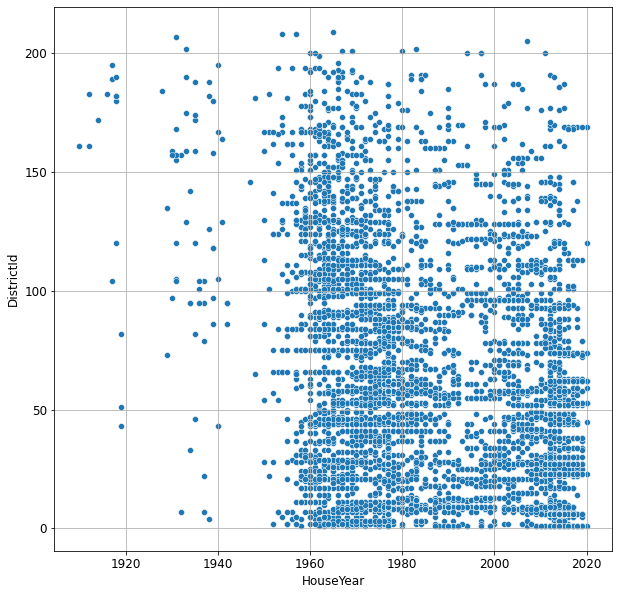

9948

In [13]:
plt.figure(figsize = (10,10))
dataindx = (train['Square'] >= 19) & (train['HouseYear'] >= 1900) & (train['HouseYear'] <= 2020) & (train['DistrictId'] >= 1)
sns.scatterplot(x = train.loc[dataindx, 'HouseYear'], y = train.loc[dataindx, 'DistrictId'])
plt.grid(b = True, which = 'both')
plt.minorticks_on
plt.show()
train.loc[dataindx, 'HouseYear'].count()

In [14]:
for hyear in range(1957,2021):
    print(hyear, ' - ' ,train.loc[train['HouseYear'] == hyear, 'DistrictId'].count())


1957  -  33
1958  -  51
1959  -  51
1960  -  121
1961  -  112
1962  -  125
1963  -  158
1964  -  150
1965  -  161
1966  -  139
1967  -  144
1968  -  163
1969  -  188
1970  -  193
1971  -  177
1972  -  177
1973  -  147
1974  -  164
1975  -  148
1976  -  150
1977  -  1084
1978  -  124
1979  -  98
1980  -  103
1981  -  97
1982  -  102
1983  -  86
1984  -  68
1985  -  54
1986  -  31
1987  -  65
1988  -  58
1989  -  53
1990  -  71
1991  -  59
1992  -  63
1993  -  44
1994  -  54
1995  -  57
1996  -  77
1997  -  63
1998  -  70
1999  -  82
2000  -  64
2001  -  62
2002  -  77
2003  -  89
2004  -  99
2005  -  102
2006  -  78
2007  -  95
2008  -  95
2009  -  96
2010  -  85
2011  -  92
2012  -  524
2013  -  344
2014  -  1342
2015  -  299
2016  -  305
2017  -  308
2018  -  175
2019  -  79
2020  -  19


In [15]:
for item in train.columns:
    print(item, ' -- ', 'Unique values:', pd.unique(train[item]), '\n', '\n', pd.value_counts((train[item])), '\n\n\n' )

Id  --  Unique values: ['11809' '3013' '8215' ... '2795' '14561' '7202'] 
 
 4788     1
9042     1
2032     1
7570     1
14345    1
        ..
9040     1
13902    1
3394     1
6455     1
13001    1
Name: Id, Length: 10000, dtype: int64 



DistrictId  --  Unique values: [ 27  22   1  94  99  44  59   6   2  88  93  90  36  96  48   8  45  63
  20   7 103  67  24  23  38 100  74  35   9 167 119 129   4  62 173  37
  60 111 124 157 138 147  66  42  41  58  75  81 110   5  57  77  11  61
 120 121 101  32  21 140  46  91  30   0  33  85  17  56  84 137 143  31
  53 163 200  78 182  73  70  98  54  55   3 159  50  49  52 127  28  83
  29 194  47 128  12 187  80 170  34 205  79 105 123  39 142 176 130  13
  15  25  89 169 113 108 132 186 106  10 139 151 144  69 189 152 125 109
  40 162  72 154  64  26  18 164  71  82  86 155 122 112 126 166 117 116
  95  87  92 168 136 165 150  68 191 145  43 188 193 146 104  51 158  97
 153 161 149 107 177 118 114 156 160  14  19 135 148 131 134 183 185 190

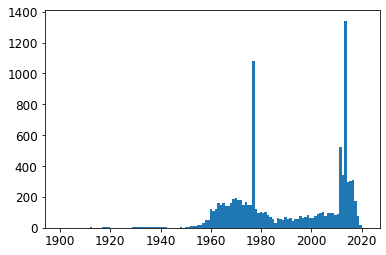

In [16]:
plt.hist(train['HouseYear'], bins = 2022-1900, range = (1900,2021), log = False)
plt.show()

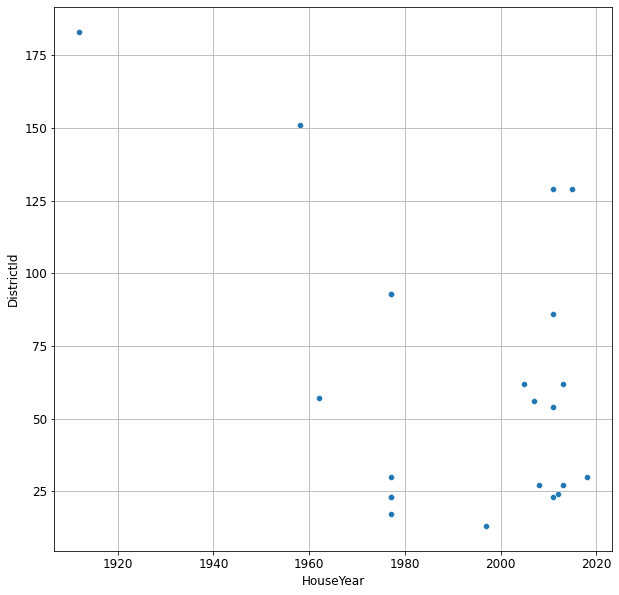

25

In [17]:
plt.figure(figsize = (10,10))
dataindx = (train['Square'] > 150) & (train['HouseYear'] <= 2020) & (train['DistrictId'] >= 1)
sns.scatterplot(x = train.loc[dataindx, 'HouseYear'], y = train.loc[dataindx, 'DistrictId'])
plt.grid(b = True, which = 'both')
plt.minorticks_on
plt.show()
train.loc[dataindx, 'HouseYear'].count()

Checking of empty elements

In [18]:
train.isnull().sum().sum()

0

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  object 
 1   DistrictId          10000 non-null  int64  
 2   Rooms               10000 non-null  int64  
 3   Square              10000 non-null  float64
 4   LifeSquare          10000 non-null  float64
 5   KitchenSquare       10000 non-null  float64
 6   Floor               10000 non-null  int64  
 7   HouseFloor          10000 non-null  float64
 8   HouseYear           10000 non-null  int64  
 9   Ecology_1           10000 non-null  float64
 10  Ecology_2           10000 non-null  int64  
 11  Ecology_3           10000 non-null  int64  
 12  Social_1            10000 non-null  int64  
 13  Social_2            10000 non-null  int64  
 14  Social_3            10000 non-null  int64  
 15  Healthcare_1        10000 non-null  float64
 16  Helth

There are some plots for price per sq.m from rooms, etc.

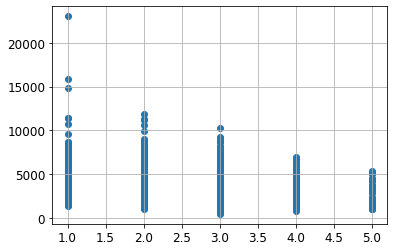

In [20]:
plt.scatter(train['Rooms'], train['Price']/train['Square'])
plt.grid(True)
plt.show()

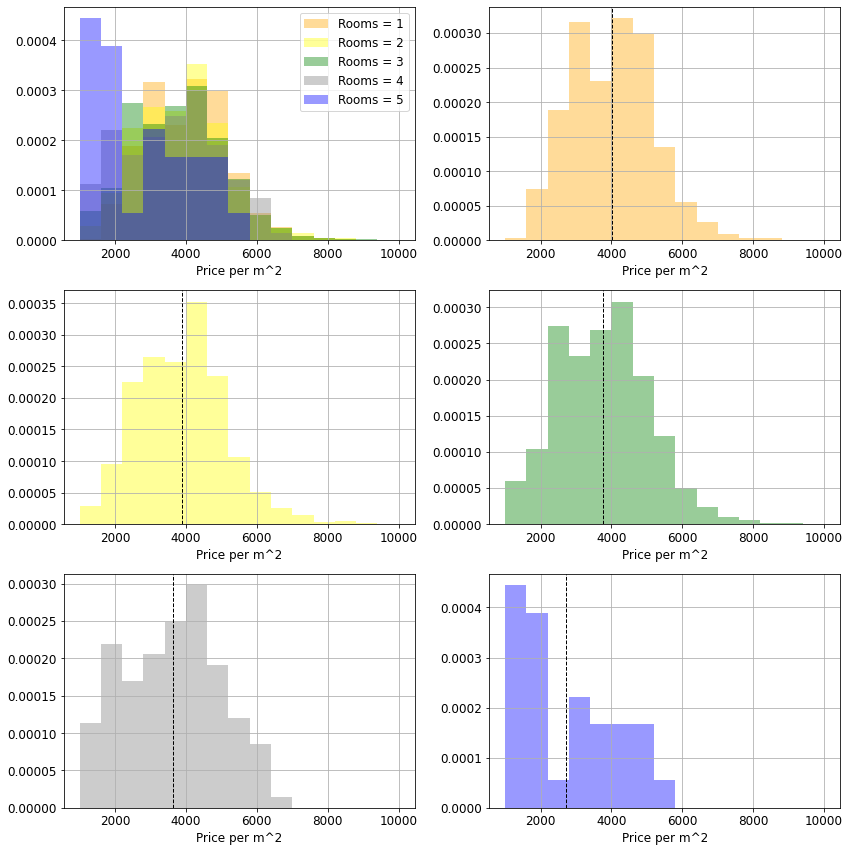

In [21]:
bins_num = 15
price_per_area = 10000
fig, axs = plt.subplots(3, 2, figsize=(12, 12), tight_layout=True)
axs[0,0].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 1) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'orange', range = [1000,10000])
axs[0,0].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 2) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'yellow', range = [1000,10000])
axs[0,0].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 3) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'green', range = [1000,10000])
axs[0,0].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 4) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'grey', range = [1000,10000])
axs[0,0].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 5) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'blue', range = [1000,10000])
axs[0,0].legend(labels=['Rooms = 1', 'Rooms = 2', 'Rooms = 3', 'Rooms = 4', 'Rooms = 5', 'Rooms = 6'])
axs[0,1].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 1) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'orange', range = [1000,10000])
axs[0,1].axvline((train['Price']/train['Square']).loc[(train['Rooms'] == 1) & ((train['Price']/train['Square']) < price_per_area)].mean(), color='k', linestyle='dashed', linewidth=1)
axs[1,0].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 2) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'yellow', range = [1000,10000])
axs[1,0].axvline((train['Price']/train['Square']).loc[(train['Rooms'] == 2) & ((train['Price']/train['Square']) < price_per_area)].mean(), color='k', linestyle='dashed', linewidth=1)
axs[1,1].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 3) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'green', range = [1000,10000])
axs[1,1].axvline((train['Price']/train['Square']).loc[(train['Rooms'] == 3) & ((train['Price']/train['Square']) < price_per_area)].mean(), color='k', linestyle='dashed', linewidth=1)
axs[2,0].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 4) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'grey', range = [1000,10000])
axs[2,0].axvline((train['Price']/train['Square']).loc[(train['Rooms'] == 4) & ((train['Price']/train['Square']) < price_per_area)].mean(), color='k', linestyle='dashed', linewidth=1)
axs[2,1].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 5) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'blue', range = [1000,10000])
axs[2,1].axvline((train['Price']/train['Square']).loc[(train['Rooms'] == 5) & ((train['Price']/train['Square']) < price_per_area)].mean(), color='k', linestyle='dashed', linewidth=1)
axs[0,0].set_xlabel('Price per m^2')
axs[0,1].set_xlabel('Price per m^2')
axs[1,0].set_xlabel('Price per m^2')
axs[1,1].set_xlabel('Price per m^2')
axs[2,0].set_xlabel('Price per m^2')
axs[2,1].set_xlabel('Price per m^2')
axs[0,0].grid(True)
axs[0,1].grid(True)
axs[1,0].grid(True)
axs[1,1].grid(True)
axs[2,0].grid(True)
axs[2,1].grid(True)
plt.show()

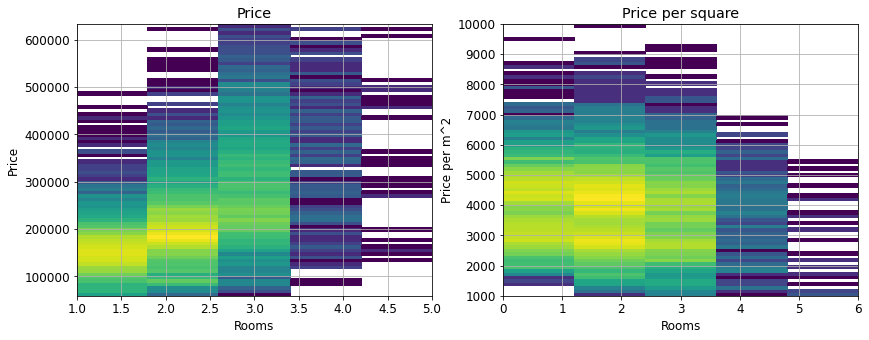

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].hist2d(train['Rooms'], train['Price'], bins=(5, 80), norm = colors.LogNorm())
axs[1].hist2d(train['Rooms'], train['Price']/train['Square'], bins=(5, 80), norm = colors.LogNorm(), range = [[0,6],[1000, 10000]])
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('Rooms')
axs[0].set_title('Price')
axs[0].set_ylabel('Price')
axs[1].set_xlabel('Rooms')
axs[1].set_title('Price per square')
axs[1].set_ylabel('Price per m^2')
plt.show()

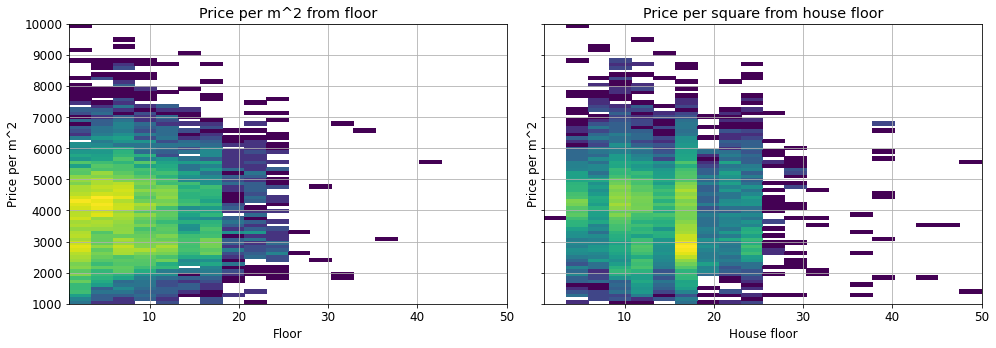

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True, tight_layout=True)
axs[0].hist2d(train['Floor'], train['Price']/train['Square'], bins=(20, 80), norm = colors.LogNorm(), range = [[1,50],[1000, 10000]])
axs[1].hist2d(train['HouseFloor'], train['Price']/train['Square'], bins=(20, 80), norm = colors.LogNorm(), range = [[1,50],[1000, 10000]])
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('Floor')
axs[0].set_title('Price per m^2 from floor')
axs[0].set_ylabel('Price per m^2')
axs[1].set_xlabel('House floor')
axs[1].set_title('Price per square from house floor')
axs[1].set_ylabel('Price per m^2')
plt.show()

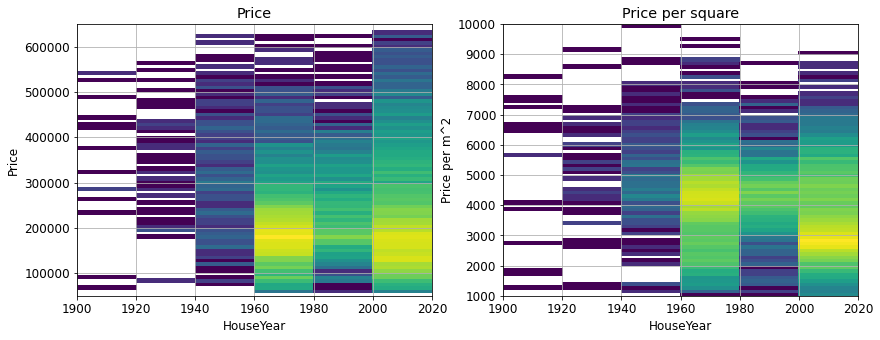

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].hist2d(train['HouseYear'], train['Price'], bins=(6, 80), norm = colors.LogNorm(), range = [[1900,2020],[50000, 650000]])
axs[1].hist2d(train['HouseYear'], train['Price']/train['Square'], bins=(6, 80), norm = colors.LogNorm(), range = [[1900,2020],[1000, 10000]])
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('HouseYear')
axs[0].set_title('Price')
axs[0].set_ylabel('Price')
axs[1].set_xlabel('HouseYear')
axs[1].set_title('Price per square')
axs[1].set_ylabel('Price per m^2')
plt.show()

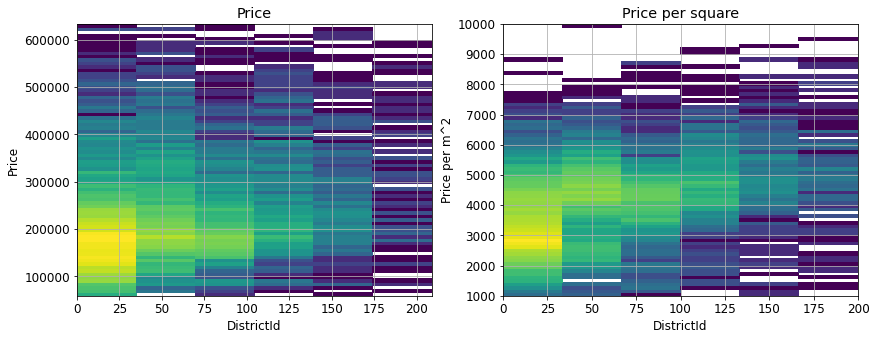

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].hist2d(train['DistrictId'], train['Price'], bins=(6, 80), norm = colors.LogNorm())
axs[1].hist2d(train['DistrictId'], train['Price']/train['Square'], bins=(6, 80), norm = colors.LogNorm(), range = [[0,200],[1000, 10000]])
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('DistrictId')
axs[0].set_title('Price')
axs[0].set_ylabel('Price')
axs[1].set_xlabel('DistrictId')
axs[1].set_title('Price per square')
axs[1].set_ylabel('Price per m^2')
plt.show()

Change Id and DistrictId types to string type.

In [26]:
train['Id'] = train['Id'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)

train.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'WrongDistr']

# 2. New numerical features

In [27]:
class FeatureGeneration:
    def __init__(self, Y):
        self.y = Y
        self.square_av_meter_price_df = None
        self.av_meter_price_df = None
        self.district_av_meter_price_df = None
        self.district_house_floor_av_meter_price_df = None
        self.rooms_av_meter_price_df = None
        self.district_rooms_av_meter_price_df = None
        self.district_house_year_rooms_av_meter_price_df = None
        self.house_year_rooms_av_meter_price_df = None
        self.district_house_floor_rooms_av_meter_price_df = None
        self.district_kitchen_square_rooms_av_meter_price_df = None
        self.district_life_square_rooms_av_meter_price_df = None
        self.flat_av_meter_price_df = None
        self.floor_meter_price_df = None
        self.district_location_df = None
        self.average_house_floor_df = None
        self.number_of_flats_df = None
        self.mean_building_year_df = None
        self.district_population_df = None
        self.district_planting_of_greenery_df = None
        self.ecology_df = None
        self.district_house_year_kitchen_square_df = None
        self.house_year_rooms_square_df = None
        self.house_year_rooms_life_square_df = None
        self.district_social_df = None
        self.district_healthcare_df = None
        self.district_shops_df = None
        self.house_floor_rooms_square_df = None
        self.house_floor_rooms_life_square_df = None
        

    def add_square_av_meter_price(self, X):
        temp = None
        X['1Square'] = round(X['Square'] / 1)
        if self.square_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['MeterPrice'] = X['Price']/X['Square']
            self.square_av_meter_price_df = X.groupby(['1Square'])['MeterPrice'].mean().reset_index()\
            .rename(columns = {'index':'1Square', 'MeterPrice':'SquareAvMeterPrice'})
            X = X.drop(columns=['MeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.square_av_meter_price_df, on = ['1Square'], how = 'left')
        X = X.drop(columns=['1Square'])
        if (X['SquareAvMeterPrice'].isnull().any()):
            if temp is None:
                temp = X['SquareAvMeterPrice'].median()
            X.loc[X['SquareAvMeterPrice'].isnull(),'SquareAvMeterPrice'] = temp
        return X
    
    def add_av_meter_price(self, X):
        temp = None
        if self.av_meter_price_df is None:
            X['Price'] = self.y.values
            X['MeterPrice'] = X['Price']/X['Square']
            self.av_meter_price_df = X.groupby(['DistrictId'])['MeterPrice'].mean().reset_index()\
            .rename(columns = {'index':'DistrictId', 'MeterPrice':'AvMeterPrice'})
            X = X.drop(columns=['MeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.av_meter_price_df, on = ['DistrictId'], how = 'left')
        if (X['AvMeterPrice'].isnull().any()):
            if temp is None:
                temp = X['AvMeterPrice'].median()
            X.loc[X['AvMeterPrice'].isnull(),'AvMeterPrice'] = temp
        return X
    
    def add_district_av_meter_price(self, X):
        temp = None
        if self.district_av_meter_price_df is None:
            X['Price'] = self.y.values
            self.district_av_meter_price_df = X.groupby('DistrictId')['Price'].mean().reset_index()\
            .rename(columns = {'index':'DistrictId'})
            district_av_square = X.groupby('DistrictId')['Square'].mean().reset_index()\
            .rename(columns = {'index':'DistrictId'})
            self.district_av_meter_price_df = self.district_av_meter_price_df.merge(district_av_square, on = 'DistrictId', how = 'left')
            self.district_av_meter_price_df['DistrictAvMeterPrice'] = self.district_av_meter_price_df["Price"]/self.district_av_meter_price_df["Square"]
            self.district_av_meter_price_df = self.district_av_meter_price_df.drop(['Price', 'Square'], axis = 1)
            X = X.drop(columns=['Price'])
        X = X.merge(self.district_av_meter_price_df, on='DistrictId', how='left')
        if (X['DistrictAvMeterPrice'].isnull().any()):
            if temp is None:
                temp = X['DistrictAvMeterPrice'].median()
            X.loc[X['DistrictAvMeterPrice'].isnull(),'DistrictAvMeterPrice'] = temp
        return X
    
    def add_district_house_floor_av_meter_price(self, X):
        temp = None
        if self.district_house_floor_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['HouseFloorMeterPrice'] = X['Price']/X['HouseFloor']/X['Square']
            self.district_house_floor_av_meter_price_df = X.groupby(['DistrictId', 'HouseFloor'])['HouseFloorMeterPrice'].median().reset_index()\
            .rename(columns = {'index':'DistrictId', 'HouseFloorMeterPrice':'DistrictHouseFloorAvMeterPrice'})
            X = X.drop(columns=['Price'])
            X = X.drop(columns=['HouseFloorMeterPrice'])
        X = X.merge(self.district_house_floor_av_meter_price_df, on = ['DistrictId', 'HouseFloor'], how = 'left')
        if (X['DistrictHouseFloorAvMeterPrice'].isnull().any()):
            if temp is None:
                temp = X['DistrictHouseFloorAvMeterPrice'].median()
            X.loc[X['DistrictHouseFloorAvMeterPrice'].isnull(),'DistrictHouseFloorAvMeterPrice'] = temp
        return X
    
    def add_rooms_av_meter_price(self, X):
        temp = None
        if self.rooms_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['RoomsMeterPrice'] = X['Price']/X['Square']
            self.rooms_av_meter_price_df = X.groupby(['Rooms'])['RoomsMeterPrice'].mean().reset_index()\
            .rename(columns={'index':'Rooms', 'RoomsMeterPrice':'RoomsAvMeterPrice'})
            X = X.drop(columns=['RoomsMeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.rooms_av_meter_price_df, on=['Rooms'], how='left')
        if (X['RoomsAvMeterPrice'].isnull().any()):
            if temp is None:
                temp = X['RoomsAvMeterPrice'].median()
            X.loc[X['RoomsAvMeterPrice'].isnull(),'RoomsAvMeterPrice'] = temp
        return X
    
    def add_district_rooms_av_meter_price(self, X):
        if self.district_rooms_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['RoomsMeterPrice'] = X['Price']/X['Square']
            self.district_rooms_av_meter_price_df = X.groupby(['DistrictId','Rooms'])['RoomsMeterPrice'].median().reset_index()\
            .rename(columns={'index':'Rooms', 'RoomsMeterPrice':'DistrictRoomsAvMeterPrice'})
            X = X.drop(columns=['RoomsMeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.district_rooms_av_meter_price_df, on=['DistrictId', 'Rooms'], how='left')
        if (X['DistrictRoomsAvMeterPrice'].isnull().any()):
            X.loc[X['DistrictRoomsAvMeterPrice'].isnull(),'DistrictRoomsAvMeterPrice'] = X.loc[X['DistrictRoomsAvMeterPrice'].isnull(),'RoomsAvMeterPrice']
        return X
    
    def add_district_house_year_rooms_av_meter_price(self, X):
        if self.district_house_year_rooms_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['RoomsMeterPrice'] = X['Price']/X['Square']
            self.district_house_year_rooms_av_meter_price_df = X.groupby(['DistrictId','Rooms', 'HouseYear'])['RoomsMeterPrice'].median().reset_index()\
            .rename(columns={'index':'Rooms', 'RoomsMeterPrice':'DistrictHouseYearRoomsAvMeterPrice'})
            X = X.drop(columns=['RoomsMeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.district_house_year_rooms_av_meter_price_df, on=['DistrictId','Rooms', 'HouseYear'], how='left')
        if (X['DistrictHouseYearRoomsAvMeterPrice'].isnull().any()):
            X.loc[X['DistrictHouseYearRoomsAvMeterPrice'].isnull(),'DistrictHouseYearRoomsAvMeterPrice'] = X.loc[X['DistrictHouseYearRoomsAvMeterPrice'].isnull(),'DistrictHouseYearRoomsAvMeterPrice'].median()
            X.loc[X['DistrictHouseYearRoomsAvMeterPrice'].isnull(),'DistrictHouseYearRoomsAvMeterPrice'] = X.loc[X['DistrictHouseYearRoomsAvMeterPrice'].isnull(),'DistrictRoomsAvMeterPrice']
        return X
    
    def add_house_year_rooms_av_meter_price(self, X):
        if self.house_year_rooms_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['RoomsMeterPrice'] = X['Price']/X['Square']
            self.house_year_rooms_av_meter_price_df = X.groupby(['Rooms', 'HouseYear'])['RoomsMeterPrice'].median().reset_index()\
            .rename(columns={'index':'Rooms', 'RoomsMeterPrice':'HouseYearRoomsAvMeterPrice'})
            X = X.drop(columns=['RoomsMeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.house_year_rooms_av_meter_price_df, on=['Rooms', 'HouseYear'], how='left')
        step = 6
        for hyear in range(1900,2020):
            if X.loc[(X['HouseYear'] == hyear), 'HouseYearRoomsAvMeterPrice'].isnull().any():
                print('check')
                wrongDataIndx = (X['HouseYear'] == hyear) & (X['HouseYearRoomsAvMeterPrice'].isnull())
                corrDataIndx = (X['HouseYear'] >= hyear - step) & (X['HouseYear'] <= hyear + step)
                X.loc[wrongDataIndx, 'HouseYearRoomsAvMeterPrice'] = X.loc[corrDataIndx, 'HouseYearRoomsAvMeterPrice'].median()
            print(X.loc[(X['HouseYear'] >= hyear - step - 7) & (X['HouseYear'] <= hyear + step + 7), 'HouseYearRoomsAvMeterPrice'].median())
            X.loc[(X['HouseYearRoomsAvMeterPrice'].isnull()), 'HouseYearRoomsAvMeterPrice'] = X.loc[(X['HouseYear'] >= hyear - step - 7) & (X['HouseYear'] <= hyear + step + 7), 'HouseYearRoomsAvMeterPrice'].median()
        print(X.loc[(X['HouseYearRoomsAvMeterPrice'].isnull()),['HouseYearRoomsAvMeterPrice', 'HouseYear']])
        return X
    
    
    def add_district_house_floor_rooms_av_meter_price(self, X):
        if self.district_house_floor_rooms_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['RoomsMeterPrice'] = X['Price']/X['Square']
            self.district_house_floor_rooms_av_meter_price_df = X.groupby(['DistrictId','Rooms', 'HouseFloor'])['RoomsMeterPrice'].median().reset_index()\
            .rename(columns={'index':'Rooms', 'RoomsMeterPrice':'DistrictHouseFloorRoomsAvMeterPrice'})
            X = X.drop(columns=['RoomsMeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.district_house_floor_rooms_av_meter_price_df, on=['DistrictId','Rooms', 'HouseFloor'], how='left')
        if (X['DistrictHouseFloorRoomsAvMeterPrice'].isnull().any()):
            X.loc[X['DistrictHouseFloorRoomsAvMeterPrice'].isnull(),'DistrictHouseFloorRoomsAvMeterPrice'] = X.loc[X['DistrictHouseFloorRoomsAvMeterPrice'].isnull(),'DistrictHouseFloorRoomsAvMeterPrice'].median()
            X.loc[X['DistrictHouseFloorRoomsAvMeterPrice'].isnull(),'DistrictHouseFloorRoomsAvMeterPrice'] = X.loc[X['DistrictHouseFloorRoomsAvMeterPrice'].isnull(),'DistrictRoomsAvMeterPrice']
        return X
    
    def add_district_kitchen_square_rooms_av_meter_price(self, X):
        if self.district_kitchen_square_rooms_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['RoomsMeterPrice'] = X['Price']/X['Square']
            self.district_kitchen_square_rooms_av_meter_price_df = X.groupby(['DistrictId','Rooms', 'KitchenSquare'])['RoomsMeterPrice'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'RoomsMeterPrice':'DistrictKitchenSquareRoomsAvMeterPrice'})
            X = X.drop(columns=['RoomsMeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.district_kitchen_square_rooms_av_meter_price_df, on=['DistrictId','Rooms', 'KitchenSquare'], how='left')
        if (X['DistrictKitchenSquareRoomsAvMeterPrice'].isnull().any()):
            X.loc[X['DistrictKitchenSquareRoomsAvMeterPrice'].isnull(),'DistrictKitchenSquareRoomsAvMeterPrice'] = X['DistrictKitchenSquareRoomsAvMeterPrice'].median()
        return X
    
    def add_district_life_square_rooms_av_meter_price(self, X):
        if self.district_life_square_rooms_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['RoomsMeterPrice'] = X['Price']/X['Square']
            self.district_life_square_rooms_av_meter_price_df = X.groupby(['DistrictId','Rooms', 'LifeSquare'])['RoomsMeterPrice'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'RoomsMeterPrice':'DistrictLifeSquareRoomsAvMeterPrice'})
            X = X.drop(columns=['RoomsMeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.district_life_square_rooms_av_meter_price_df, on=['DistrictId','Rooms', 'LifeSquare'], how='left')
        if (X['DistrictLifeSquareRoomsAvMeterPrice'].isnull().any()):
            X.loc[X['DistrictLifeSquareRoomsAvMeterPrice'].isnull(),'DistrictLifeSquareRoomsAvMeterPrice'] = X['DistrictLifeSquareRoomsAvMeterPrice'].median()
        return X
    
    def add_flat_av_meter_price(self, X):
        if self.flat_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['MeterPrice_1'] = X['Price']/X['Square'] # see add_av_meter_price
            self.flat_av_meter_price_df = X.groupby(['DistrictId'])['MeterPrice_1'].mean().reset_index()\
            .rename(columns={'index':'DistrictId', 'MeterPrice_1':'FlatAvMeterPrice'})
            X = X.drop(columns=['MeterPrice_1'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.flat_av_meter_price_df, on=['DistrictId'], how='left')
        if (X['FlatAvMeterPrice'].isnull().any()):
            X.loc[X['FlatAvMeterPrice'].isnull(),'FlatAvMeterPrice'] = X.loc[X['FlatAvMeterPrice'].isnull(),'RoomsAvMeterPrice']
        return X
    
    def add_floor_meter_price(self, X):
        temp = None
        if self.floor_meter_price_df is None:
            X['Price'] = self.y.values
            X['FloorMeterPrice'] = X['Price']/X['Floor']/X['Square']
            self.floor_meter_price_df = X.groupby(['DistrictId','Floor'])['FloorMeterPrice'].mean().reset_index()\
            .rename(columns={'index':'DistrictId', 'FloorMeterPrice':'FloorAvMeterPrice'})
            X = X.drop(columns=['FloorMeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.floor_meter_price_df, on=['DistrictId', 'Floor'], how='left')
        if X['FloorAvMeterPrice'].isnull().any():
            if temp is None:
                temp = X['FloorAvMeterPrice'].median()
            X.loc[X['FloorAvMeterPrice'].isnull(),'FloorAvMeterPrice'] = temp
        return X
    
    # ____________________________________________
    
    def add_district_location(self, X):
        temp = None
        if self.district_location_df is None:
            self.district_location_df = X.groupby('DistrictId')['HouseYear'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'HouseYear':'DistrictLocation'})
            self.district_location_df['DistrictLocation'] = self.district_location_df['DistrictLocation'].astype(int)
        X = X.merge(self.district_location_df, on='DistrictId', how='left')
        if (X['DistrictLocation'].isnull().any()):
            if temp is None:
                temp = X['DistrictLocation'].median()
            X.loc[X['DistrictLocation'].isnull(),'DistrictLocation'] = temp
        return X
    
    def add_average_house_floor(self, X):
        temp = None
        if self.average_house_floor_df is None:
            self.average_house_floor_df = X.groupby('DistrictId')['HouseFloor'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'HouseFloor':'AvHouseFloor'})
            self.average_house_floor_df['AvHouseFloor'] = self.average_house_floor_df['AvHouseFloor'].astype(int)
        X = X.merge(self.average_house_floor_df, on='DistrictId', how='left')
        if (X['AvHouseFloor'].isnull().any()):
            if temp is None:
                temp = X['AvHouseFloor'].median()
            X.loc[X['AvHouseFloor'].isnull(),'AvHouseFloor'] = temp
        return X
    
    def add_number_of_flats(self, X):
        temp = None
        if self.number_of_flats_df is None:
            self.number_of_flats_df = X['DistrictId'].value_counts().reset_index()\
            .rename(columns={'index':'DistrictId', 'DistrictId':'NumberOfFlats'})
        X = X.merge(self.number_of_flats_df, on='DistrictId', how='left')
        if (X['NumberOfFlats'].isnull().any()):
            if temp is None:
                temp = X['NumberOfFlats'].median()
            X.loc[X['NumberOfFlats'].isnull(),'NumberOfFlats'] = temp
        return X
    
    def add_mean_building_year(self, X):
        # District have some new houses
        temp = None
        if self.mean_building_year_df is None:
            self.mean_building_year_df = X.groupby('DistrictId')['HouseYear'].mean().reset_index()\
            .rename(columns={'index':'DistrictId', 'HouseYear':'MeanBuildingYear'})
            self.mean_building_year_df['MeanBuildingYear'] = self.mean_building_year_df['MeanBuildingYear'].astype(int)
        X = X.merge(self.mean_building_year_df, on='DistrictId', how='left')
        if (X['MeanBuildingYear'].isnull().any()):
            if temp is None:
                temp = X['MeanBuildingYear'].median()
            X.loc[X['MeanBuildingYear'].isnull(),'MeanBuildingYear'] = temp
        return X
    
    def add_district_population(self, X):
        # The more average rooms in flat the more people could leave in a house. The more sale announcements in district the more population in it.
        temp = None
        if self.district_population_df is None:
            self.district_population_df = X.groupby('DistrictId')['Rooms'].mean().reset_index()\
            .rename(columns={'index':'DistrictId'})
            number_of_flats = X['DistrictId'].value_counts().reset_index()\
            .rename(columns={'index':'DistrictId', 'DistrictId':'NumberOfFlats'})
            self.district_population_df = self.district_population_df.merge(number_of_flats, on='DistrictId', how='left')
            self.district_population_df['DistrictAvPopulation'] = self.district_population_df["NumberOfFlats"] / self.district_population_df["Rooms"]
            self.district_population_df = self.district_population_df.drop(['NumberOfFlats', 'Rooms'], axis = 1)
        X = X.merge(self.district_population_df, on='DistrictId', how='left')
        if (X['DistrictAvPopulation'].isnull().any()):
            if temp is None:
                temp = X['DistrictAvPopulation'].median()
            X.loc[X['DistrictAvPopulation'].isnull(),'DistrictAvPopulation'] = temp
        return X
    
    def add_district_planting_of_greenery(self, X):
        temp = None
        if self.district_planting_of_greenery_df is None:
            self.district_planting_of_greenery_df = X.groupby('DistrictId')['HouseFloor'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'HouseFloor':'Greenery'})
            self.district_planting_of_greenery_df['Greenery'] = self.district_planting_of_greenery_df['Greenery'].astype(int)
        X = X.merge(self.district_planting_of_greenery_df, on='DistrictId', how='left')
        if (X['Greenery'].isnull().any()):
            if temp is None:
                temp = X['Greenery'].median()
            X.loc[X['Greenery'].isnull(),'Greenery'] = temp
        return X
    
    def add_ecology(self, X):
        temp = None
        X['Ecology'] = X['Ecology_1'] / max(X['Ecology_1']) * X['Ecology_2'] / max(X['Ecology_2']) * X['Ecology_3'] / max(X['Ecology_3'])
        if self.ecology_df is None:
            self.ecology_df = X.groupby('DistrictId')['Ecology'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'Ecology':'DistrictAvEcology'})
            #X = X.drop(columns=['Ecology'])
        X = X.merge(self.ecology_df, on = 'DistrictId', how = 'left')
        if (X['DistrictAvEcology'].isnull().any()):
            if temp is None:
                temp = X['DistrictAvEcology'].median()
            X.loc[X['DistrictAvEcology'].isnull(),'DistrictAvEcology'] = temp
        temp = None
        if (X['Ecology'].isnull().any()):
            if temp is None:
                temp = X['Ecology'].median()
            X.loc[X['Ecology'].isnull(),'Ecology'] = temp
        return X
    
    def add_relative_house_floor(self, X):
        temp = None
        X['RelativeHouseFloor'] = X['Floor'] / X['HouseFloor']
        X.loc[X['Floor'] == 1, 'RelativeHouseFloor'] = 0
        return X
    
    def add_district_house_year_kitchen_square(self, X):
        temp = None
        if self.district_house_year_kitchen_square_df is None:
            self.district_house_year_kitchen_square_df = X.groupby(['DistrictId', 'HouseYear'])['KitchenSquare'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'KitchenSquare':'DistrHouseYearKitchenSquare'})
        X = X.merge(self.district_house_year_kitchen_square_df, on = ['DistrictId', 'HouseYear'], how = 'left')
        if (X['DistrHouseYearKitchenSquare'].isnull().any()):
            if temp is None:
                temp = X.groupby('DistrictId')['DistrHouseYearKitchenSquare'].median().reset_index()
            for item in temp['DistrictId']:
                X.loc[(X['DistrHouseYearKitchenSquare'].isnull()) & (X['DistrictId'] == item),'DistrHouseYearKitchenSquare'] = temp.loc[temp['DistrictId'] == item, 'DistrHouseYearKitchenSquare']
            if (X['DistrHouseYearKitchenSquare'].isnull().any()):
                X.loc[(X['DistrHouseYearKitchenSquare'].isnull()),'DistrHouseYearKitchenSquare'] = temp['DistrHouseYearKitchenSquare'].median()
        return X
    
    def add_house_year_rooms_square(self, X):
        temp = None
        X['RoomsSq'] = X['Square'] / X['Rooms']
        if self.house_year_rooms_square_df is None:
            self.house_year_rooms_square_df = X.groupby(['HouseYear', 'Rooms'])['RoomsSq'].median().reset_index()\
            .rename(columns={'index':'HouseYear', 'RoomsSq':'HouseYearAvRoomSquare'})
        X = X.drop(columns=['RoomsSq'])
        X = X.merge(self.house_year_rooms_square_df, on = ['HouseYear', 'Rooms'], how = 'left')
        if (X['HouseYearAvRoomSquare'].isnull().any()):
            if temp is None:
                temp = X.groupby('HouseYear')['HouseYearAvRoomSquare'].median().reset_index()
            for item in temp['HouseYear']:
                X.loc[(X['HouseYearAvRoomSquare'].isnull()) & (X['HouseYear'] == item),'HouseYearAvRoomSquare'] = temp.loc[temp['HouseYear'] == item, 'HouseYearAvRoomSquare']
            if (X['HouseYearAvRoomSquare'].isnull().any()):
                X.loc[(X['HouseYearAvRoomSquare'].isnull()),'HouseYearAvRoomSquare'] = temp['HouseYearAvRoomSquare'].median()
        return X
    
    def add_house_year_rooms_lifesquare(self, X):
        temp = None
        X['RoomsLifeSquare'] = X['LifeSquare'] / X['Rooms']
        if self.house_year_rooms_life_square_df is None:
            self.house_year_rooms_life_square_df = X.groupby(['HouseYear', 'Rooms'])['RoomsLifeSquare'].median().reset_index()\
            .rename(columns={'index':'HouseYear', 'RoomsLifeSquare':'HouseYearAvRoomLifeSquare'})
        X = X.drop(columns=['RoomsLifeSquare'])
        X = X.merge(self.house_year_rooms_life_square_df, on = ['HouseYear', 'Rooms'], how = 'left')
        if (X['HouseYearAvRoomLifeSquare'].isnull().any()):
            if temp is None:
                temp = X.groupby('HouseYear')['HouseYearAvRoomLifeSquare'].median().reset_index()
            for item in temp['HouseYear']:
                X.loc[(X['HouseYearAvRoomLifeSquare'].isnull()) & (X['HouseYear'] == item),'HouseYearAvRoomLifeSquare'] = temp.loc[temp['HouseYear'] == item, 'HouseYearAvRoomLifeSquare']
            if (X['HouseYearAvRoomLifeSquare'].isnull().any()):
                X.loc[(X['HouseYearAvRoomLifeSquare'].isnull()),'HouseYearAvRoomLifeSquare'] = temp['HouseYearAvRoomLifeSquare'].median()
        return X
    
    def add_district_social(self, X):
        temp = None
        X['Social'] = X['Social_1'] / max(X['Social_1']) * X['Social_2'] / max(X['Social_2']) * X['Social_3'] / max(X['Social_3'])
        if self.district_social_df is None:
            self.district_social_df = X.groupby('DistrictId')['Social'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'Social':'DistrictSocial'})
        X = X.drop(columns=['Social'])
        X = X.merge(self.district_social_df, on = 'DistrictId', how = 'left')
        if (X['DistrictSocial'].isnull().any()):
            if temp is None:
                temp = X['DistrictSocial'].median()
                X.loc[(X['DistrictSocial'].isnull()),'DistrictSocial'] = temp
        return X
    
    def add_district_healthcare(self, X):
        temp = None
        X['Healthcare'] = X['Healthcare_1'] / max(X['Healthcare_1']) * X['Helthcare_2'] / max(X['Helthcare_2'])
        if self.district_healthcare_df is None:
            self.district_healthcare_df = X.groupby('DistrictId')['Healthcare'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'Healthcare':'DistrictHealthcare'})
        X = X.drop(columns=['Healthcare'])
        X = X.merge(self.district_healthcare_df, on = 'DistrictId', how = 'left')
        if (X['DistrictSocial'].isnull().any()):
            if temp is None:
                temp = X['DistrictHealthcare'].median()
                X.loc[(X['DistrictHealthcare'].isnull()),'DistrictHealthcare'] = temp
        return X
    
    def add_district_shops(self, X):
        temp = None
        X['Shops'] = X['Shops_1'] / max(X['Shops_1']) * X['Shops_2'] / max(X['Shops_2'])
        if self.district_shops_df is None:
            self.district_shops_df = X.groupby('DistrictId')['Shops'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'Shops':'DistrictShops'})
        X = X.drop(columns=['Shops'])
        X = X.merge(self.district_shops_df, on = 'DistrictId', how = 'left')
        if (X['DistrictShops'].isnull().any()):
            if temp is None:
                temp = X['DistrictShops'].median()
                X.loc[(X['DistrictShops'].isnull()),'DistrictShops'] = temp
        return X
    
    def add_house_floor_rooms_square(self, X):
        temp = None
        X['RoomsSq'] = X['Square'] / X['Rooms']
        if self.house_floor_rooms_square_df is None:
            self.house_floor_rooms_square_df = X.groupby(['HouseFloor', 'Rooms'])['RoomsSq'].median().reset_index()\
            .rename(columns={'index':'HouseFloor', 'RoomsSq':'HouseFloorAvRoomSquare'})
        X = X.drop(columns=['RoomsSq'])
        X = X.merge(self.house_floor_rooms_square_df, on = ['HouseFloor', 'Rooms'], how = 'left')
        if (X['HouseFloorAvRoomSquare'].isnull().any()):
            if temp is None:
                temp = X.groupby('HouseFloor')['HouseFloorAvRoomSquare'].median().reset_index()
            for item in temp['HouseFloor']:
                wrongdataindx = ((X['HouseFloorAvRoomSquare'].isnull()) & (X['HouseFloor'] == item))
                X.loc[wrongdataindx,'HouseFloorAvRoomSquare'] = temp.loc[temp['HouseFloor'] == item, 'HouseFloorAvRoomSquare']
            if (X['HouseFloorAvRoomSquare'].isnull().any()):
                X.loc[(X['HouseFloorAvRoomSquare'].isnull()),'HouseFloorAvRoomSquare'] = temp['HouseFloorAvRoomSquare'].median()
        return X
    
    def add_house_floor_rooms_lifesquare(self, X):
        temp = None
        X['RoomsLifeSquare'] = X['LifeSquare'] / X['Rooms']
        if self.house_floor_rooms_life_square_df is None:
            self.house_floor_rooms_life_square_df = X.groupby(['HouseFloor', 'Rooms'])['RoomsLifeSquare'].median().reset_index()\
            .rename(columns={'index':'HouseFloor', 'RoomsLifeSquare':'HouseFloorAvRoomLifeSquare'})
        X = X.drop(columns=['RoomsLifeSquare'])
        X = X.merge(self.house_floor_rooms_life_square_df, on = ['HouseFloor', 'Rooms'], how = 'left')
        if (X['HouseFloorAvRoomLifeSquare'].isnull().any()):
            if temp is None:
                temp = X.groupby('HouseFloor')['HouseFloorAvRoomLifeSquare'].median().reset_index()
            for item in temp['HouseFloor']:
                X.loc[(X['HouseFloorAvRoomLifeSquare'].isnull()) & (X['HouseFloor'] == item),'HouseFloorAvRoomLifeSquare'] = temp.loc[temp['HouseFloor'] == item, 'HouseFloorAvRoomLifeSquare']
            if (X['HouseFloorAvRoomLifeSquare'].isnull().any()):
                X.loc[(X['HouseFloorAvRoomLifeSquare'].isnull()),'HouseFloorAvRoomLifeSquare'] = temp['HouseFloorAvRoomLifeSquare'].median()
        return X
    
    def add_ideal_data(self, X):
        X['IdealData'] = X['WrongRooms'] + X['WrongSquare'] + X['WrongLifeSquare'] + X['WrongKitchenSquare'] + X['WrongHouseFloor'] + X['WrongFloor'] + X['WrongHouseYear'] + X['SingleRoom'] + X['WrongDistr']
        return X
    
    def add_new_features(self, X):
        if (self.y is not None):
            X = self.add_square_av_meter_price(X)
            X = self.add_av_meter_price(X)
            X = self.add_district_av_meter_price(X)
            X = self.add_district_house_floor_av_meter_price(X)
            X = self.add_rooms_av_meter_price(X)
            X = self.add_district_rooms_av_meter_price(X)
            X = self.add_district_house_year_rooms_av_meter_price(X)
            X = self.add_house_year_rooms_av_meter_price(X)
            X = self.add_district_house_floor_rooms_av_meter_price(X)
            X = self.add_district_kitchen_square_rooms_av_meter_price(X)
            X = self.add_district_life_square_rooms_av_meter_price(X)
            X = self.add_flat_av_meter_price(X)
            X = self.add_floor_meter_price(X)
        X = self.add_district_location(X)
        X = self.add_average_house_floor(X)
        X = self.add_number_of_flats(X)
        X = self.add_mean_building_year(X)
        X = self.add_district_population(X)
        X = self.add_district_planting_of_greenery(X)
        X = self.add_ecology(X)
        X = self.add_relative_house_floor(X)
        X = self.add_district_house_year_kitchen_square(X)
        X = self.add_house_year_rooms_square(X)
        X = self.add_house_year_rooms_lifesquare(X)
        X = self.add_district_social(X)
        X = self.add_district_healthcare(X)
        X = self.add_district_shops(X)
        X = self.add_house_floor_rooms_square(X)
        X = self.add_house_floor_rooms_lifesquare(X)
        X = self.add_ideal_data(X)
        return X

# 3. Features selection

In [28]:
train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'WrongDistr',
 'WrongSquare',
 'WrongHouseYear',
 'WrongHouseFloor',
 'WrongFloor',
 'WrongRooms',
 'SingleRoom',
 'WrongLifeSquare',
 'WrongKitchenSquare']

In [29]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['AvMeterPrice','DistrictHouseFloorAvMeterPrice', 
                     'DistrictRoomsAvMeterPrice', 'DistrictHouseYearRoomsAvMeterPrice', 'HouseYearRoomsAvMeterPrice',
                     'DistrictHouseFloorRoomsAvMeterPrice', 'DistrictKitchenSquareRoomsAvMeterPrice',
                     'FloorAvMeterPrice', 'DistrictLocation', 'NumberOfFlats', 'MeanBuildingYear', 
                     'DistrictAvPopulation', 'DistrictAvEcology', 'RelativeHouseFloor', 
                     'HouseYearAvRoomSquare', 
                     'DistrictSocial', 'HouseFloorAvRoomSquare', 
                     'IdealData']
# full dataset
"""feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2', 'WrongRooms', 'WrongSquare', 'WrongLifeSquare',
                 'WrongKitchenSquare', 'WrongHouseFloor', 'WrongFloor', 'WrongHouseYear', 'SingleRoom', 'WrongDistr']
new_feature_names = ['SquareAvMeterPrice','AvMeterPrice','DistrictAvMeterPrice', 'DistrictHouseFloorAvMeterPrice', 
                    'RoomsAvMeterPrice', 
                     'DistrictRoomsAvMeterPrice', 'DistrictHouseYearRoomsAvMeterPrice', 'HouseYearRoomsAvMeterPrice',
                     'DistrictHouseFloorRoomsAvMeterPrice', 'DistrictKitchenSquareRoomsAvMeterPrice',
                     'DistrictLifeSquareRoomsAvMeterPrice', 'FlatAvMeterPrice', 
                     'FloorAvMeterPrice', 'DistrictLocation', 'AvHouseFloor', 'NumberOfFlats', 'MeanBuildingYear', 
                     'DistrictAvPopulation', 'Greenery', 'Ecology', 'DistrictAvEcology', 'RelativeHouseFloor', 
                     'DistrHouseYearKitchenSquare', 'HouseYearAvRoomSquare', 'HouseYearAvRoomLifeSquare', 
                     'DistrictSocial', 'DistrictHealthcare', 'DistrictShops', 'HouseFloorAvRoomSquare', 
                     'HouseFloorAvRoomLifeSquare', 'IdealData'] """
target_name = 'Price'

# 4. Train and set subdivision

In [30]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)
X = train.drop(columns = target_name)
y = train[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33, shuffle = True, random_state = 21)
#print(X_train.shape, X_valid.shape, test.shape)

In [31]:
preprocessor = DataPreprocessing()
X_train = preprocessor.data_correction(X_train)
X_valid = preprocessor.data_correction(X_valid)
test = preprocessor.data_correction(test)
#print(X_train.shape, X_valid.shape, test.shape)

In [32]:
test['HouseYear'].median()

1989.0

# 5. New features add to train and test

In [33]:
newfeatures = FeatureGeneration(y_train)
print(X_train.columns.tolist())

['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'WrongDistr', 'WrongSquare', 'WrongHouseYear', 'WrongHouseFloor', 'WrongFloor', 'WrongRooms', 'SingleRoom', 'WrongLifeSquare', 'WrongKitchenSquare']


In [34]:
X_train = newfeatures.add_new_features(X_train)
X_valid = newfeatures.add_new_features(X_valid)
valid = X_valid.copy()
test = newfeatures.add_new_features(test)
X_train_initial, X_valid_initial, y_train_initial, y_valid_initial = X_train, X_valid, y_train, y_valid
test_initial = test
X_train.shape, X_valid.shape, test.shape

3013.8003802723406
4143.440978112229
4143.440978112229
4143.440978112229
4143.440978112229
5286.384046516372
4502.07000643747
4502.07000643747
4502.07000643747
4502.07000643747
4502.07000643747
4502.07000643747
4502.07000643747
4502.07000643747
4502.07000643747
4784.6585382270105
4502.07000643747
4993.40887391941
5030.327971967981
5030.327971967981
5142.952150134328
5199.132865772514
5199.132865772514
5208.895048012309
5199.132865772514
5199.132865772514
5208.895048012309
5208.895048012309
5199.132865772514
5218.6572302521045
5218.6572302521045
5218.6572302521045
5208.895048012309
5218.6572302521045
5274.138249143509
5329.619268034912
5329.619268034912
5199.132865772514
5199.132865772514
5042.039838360987
5042.039838360987
4972.680880449983
4866.015865521669
4866.015865521669
4891.5555526823455
4891.5555526823455
4798.259685197531
4578.61365902388
4558.709800190933
4530.2949529855105
4530.2949529855105
4428.57472276315
4428.57472276315
4313.093997713486
4313.093997713486
4313.093997713

((6700, 59), (3300, 59), (5000, 59))

In [35]:
#X_train = X_train_initial[feature_names + new_feature_names]
#X_valid = X_valid_initial[feature_names + new_feature_names]
#test = test_initial[feature_names + new_feature_names]

X_train = X_train_initial[feature_names]
X_valid = X_valid_initial[feature_names]
test = test_initial[feature_names]
X_train.shape, X_valid.shape, test.shape

((6700, 17), (3300, 17), (5000, 17))

Check NaN values through all datasets

In [36]:
X_train.isnull().sum().sum(), X_valid.isnull().sum().sum(), y_train.isnull().sum()

(0, 0, 0)

# 6. Predictions

# Random Forest Regressor

In [37]:
### rf_model = RandomForestRegressor(random_state = 21, criterion = 'mse')
#n_estimators=100, *, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None
rf_model = RandomForestRegressor(random_state = 21, n_estimators=200, criterion = 'mse', min_samples_leaf=2,
                                 min_weight_fraction_leaf = 0.0005)
rf_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=2, min_weight_fraction_leaf=0.0005,
                      n_estimators=200, random_state=21)

Train R2:	0.908
Test R2:	0.734


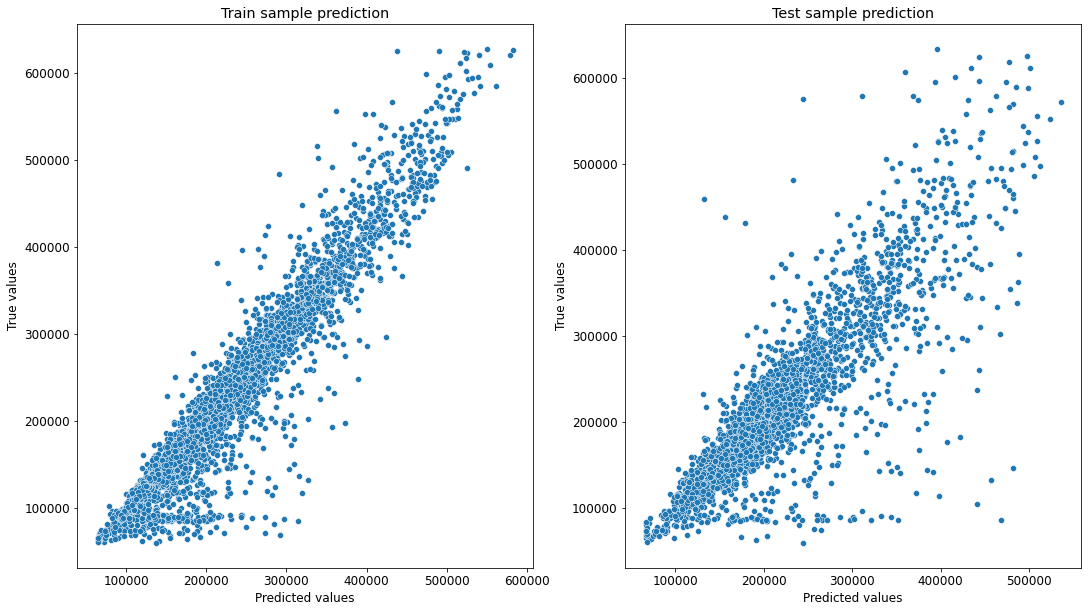

In [38]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)
y_test_preds_rf = y_test_preds.copy()
rf_model.score(X_valid, y_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [39]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring = 'r2', cv = KFold(n_splits = 3, shuffle = True, random_state = 21))
print(cv_score)
cv_score.mean()

[0.71692166 0.65539622 0.72309494]


0.6984709402488914

In [40]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns = ['feature_name', 'importance'])
feature_importances.sort_values(by = 'importance', ascending = False)

,feature_name,importance
2,Square,0.365919
11,Social_1,0.115792
12,Social_2,0.097812
1,Rooms,0.094156
13,Social_3,0.060537
0,DistrictId,0.054306
8,Ecology_1,0.045293
3,LifeSquare,0.042211
7,HouseYear,0.032194
6,HouseFloor,0.025506


# Gradient Boosting Regressor

In [41]:
"""(*, loss='ls', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', 
min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
min_impurity_split=None, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, 
warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)"""
gb_model = GradientBoostingRegressor(loss='ls', learning_rate=0.04, n_estimators=300, subsample=1.0, 
                                     min_weight_fraction_leaf=0.0005, max_depth=7, max_features=17, random_state=21)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)
y_test_preds_gb = y_test_preds.copy()

gb_model.score(X_valid, y_valid)

0.7461037425880006

Train R2:	0.924
Test R2:	0.746


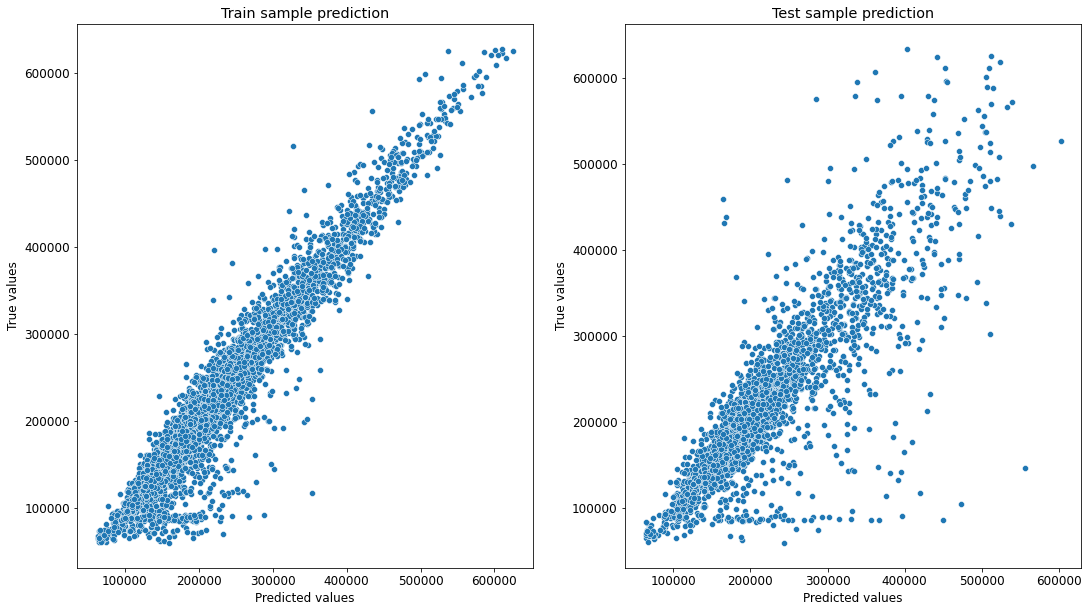

In [42]:
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [43]:
cv_score = cross_val_score(gb_model, X_valid, y_valid, scoring = 'r2', cv = KFold(n_splits = 3, shuffle = True, random_state = 21))
print(cv_score)
cv_score.mean()

[0.71829309 0.66924456 0.6363108 ]


0.6746161492921782

In [44]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns = ['feature_name', 'importance'])
feature_importances.sort_values(by = 'importance', ascending = False)

,feature_name,importance
2,Square,0.428351
12,Social_2,0.147694
11,Social_1,0.084615
13,Social_3,0.071698
0,DistrictId,0.059524
8,Ecology_1,0.044800
3,LifeSquare,0.039870
7,HouseYear,0.033896
6,HouseFloor,0.027342
5,Floor,0.019145


# Voting Regressor

Train R2:	0.923
Test R2:	0.748


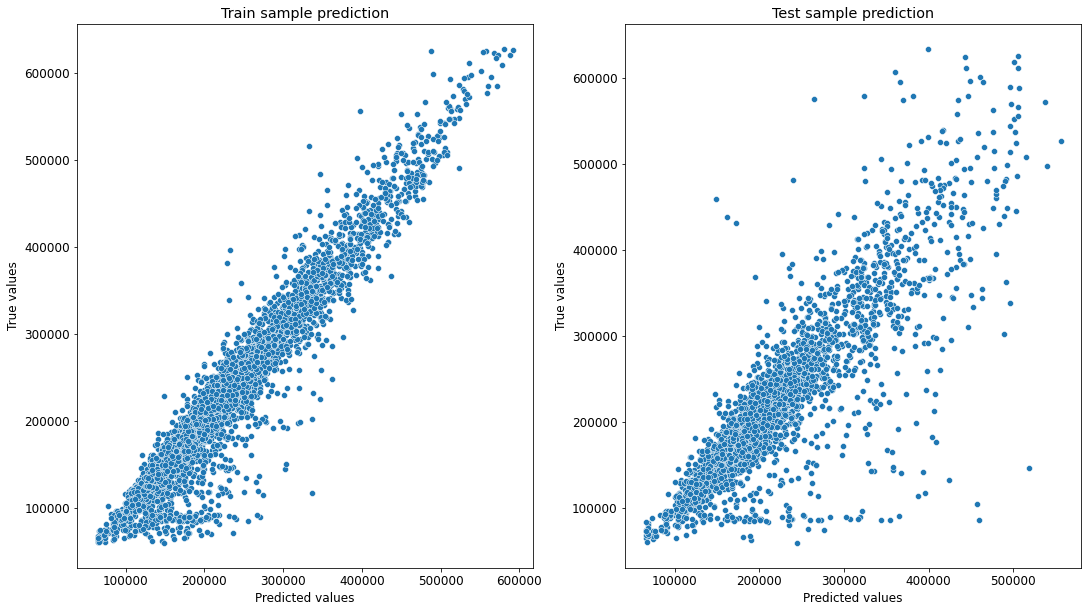

In [45]:
votingregr = VotingRegressor([('rf_model', rf_model), ('gb_model', gb_model)], n_jobs = -1)
votingregr.fit(X_train, y_train)
y_train_preds = votingregr.predict(X_train)
y_test_preds = votingregr.predict(X_valid)
y_test_preds_vr = y_test_preds.copy()

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [46]:
cv_score = cross_val_score(votingregr, X_train, y_train, scoring = 'r2', cv = KFold(n_splits = 3, shuffle = True, random_state = 21))
print(cv_score)
cv_score.mean()

[0.72606155 0.67188905 0.73480957]


0.7109200588880737

# 7. Test dataset price prediction

 733 75

In [47]:
#submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
#submit.head()

In [48]:
#predictions = votingregr.predict(test)
#predictions

In [49]:
#submit['Price'] = predictions
#submit.head()

In [50]:
#submit.to_csv('VotingRegrsubmit.csv', index=False)